**Imports**

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
!pip install pytorch_tabular
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix
from fastai.tabular.all import *
import seaborn as sns
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.6/316.6 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 88.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.4 MB/s eta 0:00:00
   

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 15.3 MB/s eta 0:00:00


**Subject-Based Classifier**

In [106]:
def classify_grade_base(score, max_score=50, interval=15):
    excellent_threshold = max_score * 0.85  # 42.5
    good_threshold = max_score * 0.7        # 35
    medium_threshold = max_score * 0.55     # 27.5
    sufficient_threshold = max_score * 0.4  # 20

    if score > excellent_threshold:
        return "EXCELLENT"
    elif good_threshold < score <= excellent_threshold:
        return "GOOD"
    elif medium_threshold < score <= good_threshold:
        return "AVERAGE"
    elif sufficient_threshold < score <= medium_threshold:
        return "SATISFACTORY"
    else:
        return "FAIL"

#test_scores = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
#results = {score: classify_grade_base(score) for score in test_scores}
#print(results)

**Performance-Tiered Classifier**

In [78]:
def classify_grade(score, max_score=50):
    high_threshold = max_score * 0.6  # Top 60% and above
    medium_threshold = max_score * 0.4  # Middle 30-60%

    if score >= high_threshold:
        return "HIGH"
    elif score >= medium_threshold:
        return "AVERAGE"
    else:
        return "LOW"

#test_scores = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
#results = {score: classify_grade(score) for score in test_scores}
#print(results)

**Buffer-Zone Classifier**

In [98]:
def classify_grade(score, max_score=50, interval=15, buffer=0.06):
    # Define grade thresholds
    excellent_threshold = max_score * 0.85
    good_threshold = max_score * 0.7
    medium_threshold = max_score * 0.55
    sufficient_threshold = max_score * 0.4

    buffer_zone = max_score * buffer

    # Apply grading logic with buffer zones
    if score > excellent_threshold or (excellent_threshold - buffer_zone) <= score:
        return "EXCELLENT"
    elif good_threshold < score <= excellent_threshold or (good_threshold - buffer_zone) <= score < excellent_threshold:
        return "GOOD"
    elif medium_threshold < score <= good_threshold or (medium_threshold - buffer_zone) <= score < good_threshold:
        return "AVERAGE"
    elif sufficient_threshold < score <= medium_threshold or (sufficient_threshold - buffer_zone) <= score < medium_threshold:
        return "SATISFACTORY"
    else:
        return "FAIL"

#test_scores = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
#results = {score: classify_grade(score) for score in test_scores}
#print(results)

**Dataset without groups and times**

In [6]:
file_path = "./dataset_without_groups_and_time.xlsx"
grade_interval = 15
data_first_to_five = pd.read_excel(file_path)
data_first_to_six = pd.read_excel(file_path)

XFive = data_first_to_five.drop(columns=['Final_Exam', 'Bonus_Weekly_Exam_Retake', 'AnonymId', 'Sixth_Weekly_Exam','Seventh_Weekly_Exam','Eighth_Weekly_Exam','Ninth_Weekly_Exam', 'Tenth_Weekly_Exam'])
YFive = data_first_to_five['Final_Exam']

XSix = data_first_to_six.drop(columns=['Final_Exam', 'Bonus_Weekly_Exam_Retake', 'AnonymId', 'Seventh_Weekly_Exam','Eighth_Weekly_Exam','Ninth_Weekly_Exam', 'Tenth_Weekly_Exam'])
YSix = data_first_to_six['Final_Exam']

print(XFive)
print(XSix)

print(YFive)
print(YSix)

# 1. Split into 80% train_val and 20% test
XFive_train_val, XFive_test, YFive_train_val, YFive_test = train_test_split(XFive, YFive, test_size=0.2, random_state=42)
XSix_train_val, XSix_test, YSix_train_val, YSix_test = train_test_split(XSix, YSix, test_size=0.2, random_state=42)

# 2. Split train_val into 75% train and 25% val → 60% train, 20% val
XFive_train, XFive_val, YFive_train, YFive_val = train_test_split(XFive_train_val, YFive_train_val, test_size=0.25, random_state=42)
XSix_train, XSix_val, YSix_train, YSix_val = train_test_split(XSix_train_val, YSix_train_val, test_size=0.25, random_state=42)

# 3. Scale all sets
scaler_five = StandardScaler()
XFive_train_scaled = scaler_five.fit_transform(XFive_train)
XFive_val_scaled = scaler_five.transform(XFive_val)
XFive_test_scaled = scaler_five.transform(XFive_test)

scaler_six = StandardScaler()
XSix_train_scaled = scaler_six.fit_transform(XSix_train)
XSix_val_scaled = scaler_six.transform(XSix_val)
XSix_test_scaled = scaler_six.transform(XSix_test)

**Dataset with groups and times**

In [7]:
file_path = "./dataset_with_groups_and_time.xlsx"
grade_interval = 15
data_first_to_five = pd.read_excel(file_path)
data_first_to_six = pd.read_excel(file_path)

XFive = data_first_to_five.drop(columns=['Final_Exam','Bonus_Weekly_Exam_Retake', 'AnonymId', 'Sixth_Weekly_Exam','Seventh_Weekly_Exam','Eighth_Weekly_Exam','Ninth_Weekly_Exam', 'Tenth_Weekly_Exam'])
YFive = data_first_to_five['Final_Exam']

XSix = data_first_to_six.drop(columns=['Final_Exam','Bonus_Weekly_Exam_Retake', 'AnonymId', 'Seventh_Weekly_Exam','Eighth_Weekly_Exam','Ninth_Weekly_Exam', 'Tenth_Weekly_Exam'])
YSix = data_first_to_six['Final_Exam']

print(XFive)
print(XSix)

print(YFive)
print(YSix)

# 1. Split into 80% train_val and 20% test
XFive_train_val, XFive_test, YFive_train_val, YFive_test = train_test_split(XFive, YFive, test_size=0.2, random_state=42)
XSix_train_val, XSix_test, YSix_train_val, YSix_test = train_test_split(XSix, YSix, test_size=0.2, random_state=42)

# 2. Split train_val into 75% train and 25% val → 60% train, 20% val
XFive_train, XFive_val, YFive_train, YFive_val = train_test_split(XFive_train_val, YFive_train_val, test_size=0.25, random_state=42)
XSix_train, XSix_val, YSix_train, YSix_val = train_test_split(XSix_train_val, YSix_train_val, test_size=0.25, random_state=42)

# 3. Scale all sets
scaler_five = StandardScaler()
XFive_train_scaled = scaler_five.fit_transform(XFive_train)
XFive_val_scaled = scaler_five.transform(XFive_val)
XFive_test_scaled = scaler_five.transform(XFive_test)

scaler_six = StandardScaler()
XSix_train_scaled = scaler_six.fit_transform(XSix_train)
XSix_val_scaled = scaler_six.transform(XSix_val)
XSix_test_scaled = scaler_six.transform(XSix_test)

**Metrics calculation**

In [107]:
def calculate_metrics(y_test, y_pred):
    test_grades = y_test.apply(lambda x: classify_grade_base(x))
    actual_grades = pd.Series(y_pred).apply(lambda x: classify_grade_base(x))
    metrics = {
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "Accuracy": accuracy_score(test_grades,actual_grades)
    }
    return metrics

**Plot generation**

In [108]:
def generate_metrics_comparison(rf_five_values, rf_six_values, title):
    metrics = ['MSE', 'RMSE', 'MAE', 'R²']
    x = np.arange(len(metrics))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, rf_five_values, width, label='Model (5 weekly exams)', color='blue')
    bars2 = ax.bar(x + width/2, rf_six_values, width, label='Model (6 weekly exams)', color='orange')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def generate_confusion_matrices(y_pred_five, y_pred_six):
    YFive_test_grades = YFive_test.apply(lambda x: classify_grade_base(x))
    YSix_test_grades = YSix_test.apply(lambda x: classify_grade_base(x))
    y_pred_five_grades = pd.Series(y_pred_five).apply(lambda x: classify_grade_base(x))
    y_pred_six_grades = pd.Series(y_pred_six).apply(lambda x: classify_grade_base(x))

    confusion_five = confusion_matrix(YFive_test_grades, y_pred_five_grades, labels=['FAIL', 'SUFFICIENT', 'MEDIUM', 'GOOD', 'EXCELLENT'])
    confusion_six = confusion_matrix(YSix_test_grades, y_pred_six_grades, labels=['FAIL', 'SUFFICIENT', 'MEDIUM', 'GOOD', 'EXCELLENT'])

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    sns.heatmap(confusion_five, annot=True, fmt='d', cmap='Blues',
                xticklabels=['FAIL', 'SUFFICIENT', 'MEDIUM', 'GOOD', 'EXCELLENT'],
                yticklabels=['FAIL', 'SUFFICIENT', 'MEDIUM', 'GOOD', 'EXCELLENT'], ax=axes[0])
    axes[0].set_title("Model (5 weekly exams)")
    axes[0].set_xlabel("Predicted Grade")
    axes[0].set_ylabel("Actual Grade")

    sns.heatmap(confusion_six, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['FAIL', 'SUFFICIENT', 'MEDIUM', 'GOOD', 'EXCELLENT'],
                yticklabels=['FAIL', 'SUFFICIENT', 'MEDIUM', 'GOOD', 'EXCELLENT'], ax=axes[1])
    axes[1].set_title("Model (6 weekly exams)")
    axes[1].set_xlabel("Predicted Grade")
    axes[1].set_ylabel("Actual Grade")

    plt.tight_layout()
    plt.show()


"""def generate_confusion_matrices(y_pred_five, y_pred_six):
    YFive_test_grades = YFive_test.apply(lambda x: classify_grade(x))
    YSix_test_grades = YSix_test.apply(lambda x: classify_grade(x))
    y_pred_five_grades = pd.Series(y_pred_five).apply(lambda x: classify_grade(x))
    y_pred_six_grades = pd.Series(y_pred_six).apply(lambda x: classify_grade(x))

    confusion_five = confusion_matrix(YFive_test_grades, y_pred_five_grades, labels=['LOW', 'MEDIUM', 'HIGH'])
    confusion_six = confusion_matrix(YSix_test_grades, y_pred_six_grades, labels=['LOW', 'MEDIUM', 'HIGH'])

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    sns.heatmap(confusion_five, annot=True, fmt='d', cmap='Blues',
                xticklabels=['LOW', 'MEDIUM', 'HIGH'],
                yticklabels=['LOW', 'MEDIUM', 'HIGH'], ax=axes[0])
    axes[0].set_title("Model (5 weekly exams)")
    axes[0].set_xlabel("Predicted Grade")
    axes[0].set_ylabel("Actual Grade")

    sns.heatmap(confusion_six, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['LOW', 'MEDIUM', 'HIGH'],
                yticklabels=['LOW', 'MEDIUM', 'HIGH'], ax=axes[1])
    axes[1].set_title("Model (6 weekly exams)")
    axes[1].set_xlabel("Predicted Grade")
    axes[1].set_ylabel("Actual Grade")

    plt.tight_layout()
    plt.show()"""

def generate_predicted_vs_actual_comparison(YFive_test, y_pred_rf_five, YSix_test, y_pred_rf_six, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(YFive_test, y_pred_rf_five, alpha=0.6, color='blue', label='Model (5 weekly exams)')
    plt.scatter(YSix_test, y_pred_rf_six, alpha=0.6, color='orange', label='Model (6 weekly exams)')
    plt.plot([min(YFive_test), max(YFive_test)], [min(YFive_test), max(YFive_test)], color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def generate_accuracy_comparison(accuracy_five, accuracy_six, title):
    models = ['Model (5 weekly exams)', 'Model (6 weekly exams)']
    accuracies = [accuracy_five, accuracy_six]

    plt.figure(figsize=(8, 6))
    plt.bar(models, accuracies, color=['blue', 'orange'])
    plt.ylim(0, 1)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title(title)

    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', fontsize=12, color='black')

    plt.tight_layout()
    plt.show()

**TabnetRegressor Model**

In [89]:
tabnet_model_five = TabNetRegressor(
    n_d=48,
    n_a=48,
    n_steps=8,
    lambda_sparse=1e-5,
    momentum=0.6,
    gamma=1.8,
    mask_type="entmax"
)

X_train_five_scaled = XFive_train_scaled.astype(np.float32)
X_test_five_scaled = XFive_test_scaled.astype(np.float32)
X_val_five_scaled = XFive_val_scaled.astype(np.float32)

y_five_train = YFive_train.values.astype(np.float32).reshape(-1, 1)
y_five_test = YFive_test.values.astype(np.float32).reshape(-1, 1)
y_five_val = YFive_val.values.astype(np.float32).reshape(-1, 1)

tabnet_model_five.fit(
    X_train=X_train_five_scaled,
    y_train=y_five_train,
    eval_set=[(X_val_five_scaled, y_five_val)],
    max_epochs=100,
    patience=15,
    batch_size=32,
    virtual_batch_size=16
)

test_five_predictions = tabnet_model_five.predict(X_test_five_scaled)

tabnet_model_six = TabNetRegressor(
    n_d=48,
    n_a=48,
    n_steps=8,
    lambda_sparse=1e-5,
    momentum=0.6,
    gamma=1.8,
    mask_type="entmax"
)

X_train_six_scaled = XSix_train_scaled.astype(np.float32)
X_test_six_scaled = XSix_test_scaled.astype(np.float32)
X_val_six_scaled = XSix_val_scaled.astype(np.float32)

y_six_train = YSix_train.values.astype(np.float32).reshape(-1, 1)
y_six_test = YSix_test.values.astype(np.float32).reshape(-1, 1)
y_six_val = YSix_val.values.astype(np.float32).reshape(-1, 1)

tabnet_model_six.fit(
    X_train=X_train_six_scaled,
    y_train=y_six_train,
    eval_set=[(X_val_six_scaled, y_six_val)],
    max_epochs=100,
    patience=15,
    batch_size=32,
    virtual_batch_size=16
)

test_six_predictions = tabnet_model_six.predict(X_test_six_scaled)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 492.76035| val_0_mse: 176.19315|  0:00:01s
epoch 1  | loss: 148.10073| val_0_mse: 149.15605|  0:00:03s
epoch 2  | loss: 145.12742| val_0_mse: 129.06558|  0:00:04s
epoch 3  | loss: 136.1803| val_0_mse: 105.27447|  0:00:06s
epoch 4  | loss: 117.96035| val_0_mse: 88.21424|  0:00:07s
epoch 5  | loss: 108.84098| val_0_mse: 102.94801|  0:00:09s
epoch 6  | loss: 107.04905| val_0_mse: 90.61236|  0:00:10s
epoch 7  | loss: 126.2393| val_0_mse: 80.68962|  0:00:12s
epoch 8  | loss: 96.53864| val_0_mse: 78.81508|  0:00:13s
epoch 9  | loss: 100.16608| val_0_mse: 81.06558|  0:00:15s
epoch 10 | loss: 92.47868| val_0_mse: 77.16696|  0:00:17s
epoch 11 | loss: 98.64493| val_0_mse: 110.72272|  0:00:18s
epoch 12 | loss: 90.20693| val_0_mse: 78.75517|  0:00:20s
epoch 13 | loss: 88.37825| val_0_mse: 89.65116|  0:00:21s
epoch 14 | loss: 93.89964| val_0_mse: 76.78015|  0:00:23s
epoch 15 | loss: 83.3846 | val_0_mse: 166.83977|  0:00:24s
epoch 16 | loss: 83.38967| val_0_mse: 94.95219|  0:00:26s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 595.58252| val_0_mse: 284.66791|  0:00:01s
epoch 1  | loss: 165.22808| val_0_mse: 132.2417|  0:00:02s
epoch 2  | loss: 145.54576| val_0_mse: 140.33223|  0:00:04s
epoch 3  | loss: 136.19078| val_0_mse: 125.84317|  0:00:05s
epoch 4  | loss: 135.9551| val_0_mse: 187.57553|  0:00:07s
epoch 5  | loss: 128.71274| val_0_mse: 109.26049|  0:00:08s
epoch 6  | loss: 113.38992| val_0_mse: 125.20337|  0:00:10s
epoch 7  | loss: 100.99783| val_0_mse: 76.26705|  0:00:11s
epoch 8  | loss: 112.18815| val_0_mse: 75.94638|  0:00:13s
epoch 9  | loss: 96.85027| val_0_mse: 74.67318|  0:00:14s
epoch 10 | loss: 103.27945| val_0_mse: 77.01183|  0:00:16s
epoch 11 | loss: 97.93716| val_0_mse: 78.98762|  0:00:17s
epoch 12 | loss: 93.40039| val_0_mse: 75.63688|  0:00:19s
epoch 13 | loss: 99.74031| val_0_mse: 75.76553|  0:00:20s
epoch 14 | loss: 94.7489 | val_0_mse: 72.60682|  0:00:22s
epoch 15 | loss: 92.60554| val_0_mse: 74.26115|  0:00:23s
epoch 16 | loss: 92.65417| val_0_mse: 82.06684|  0:00:25s

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


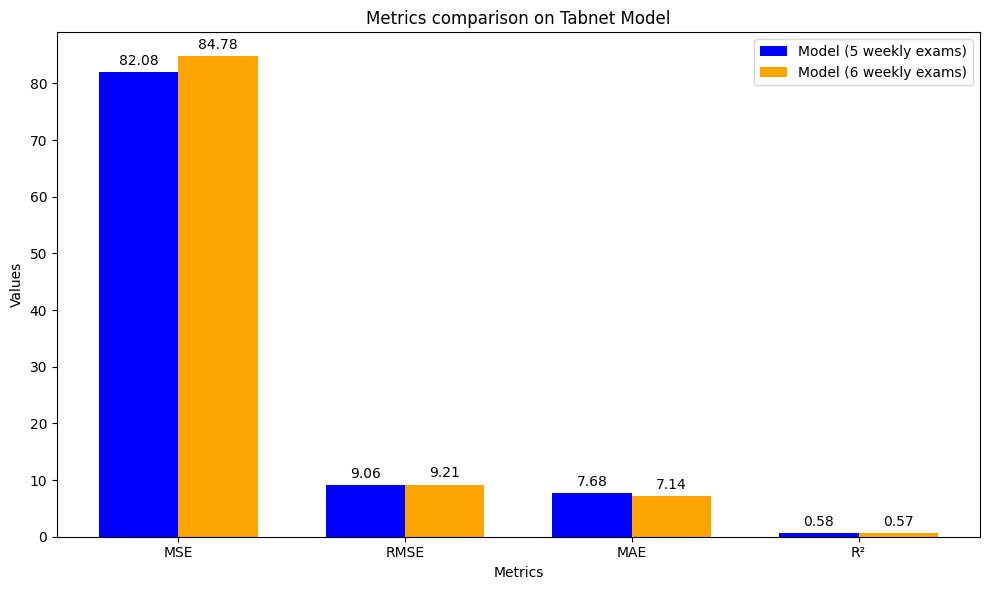

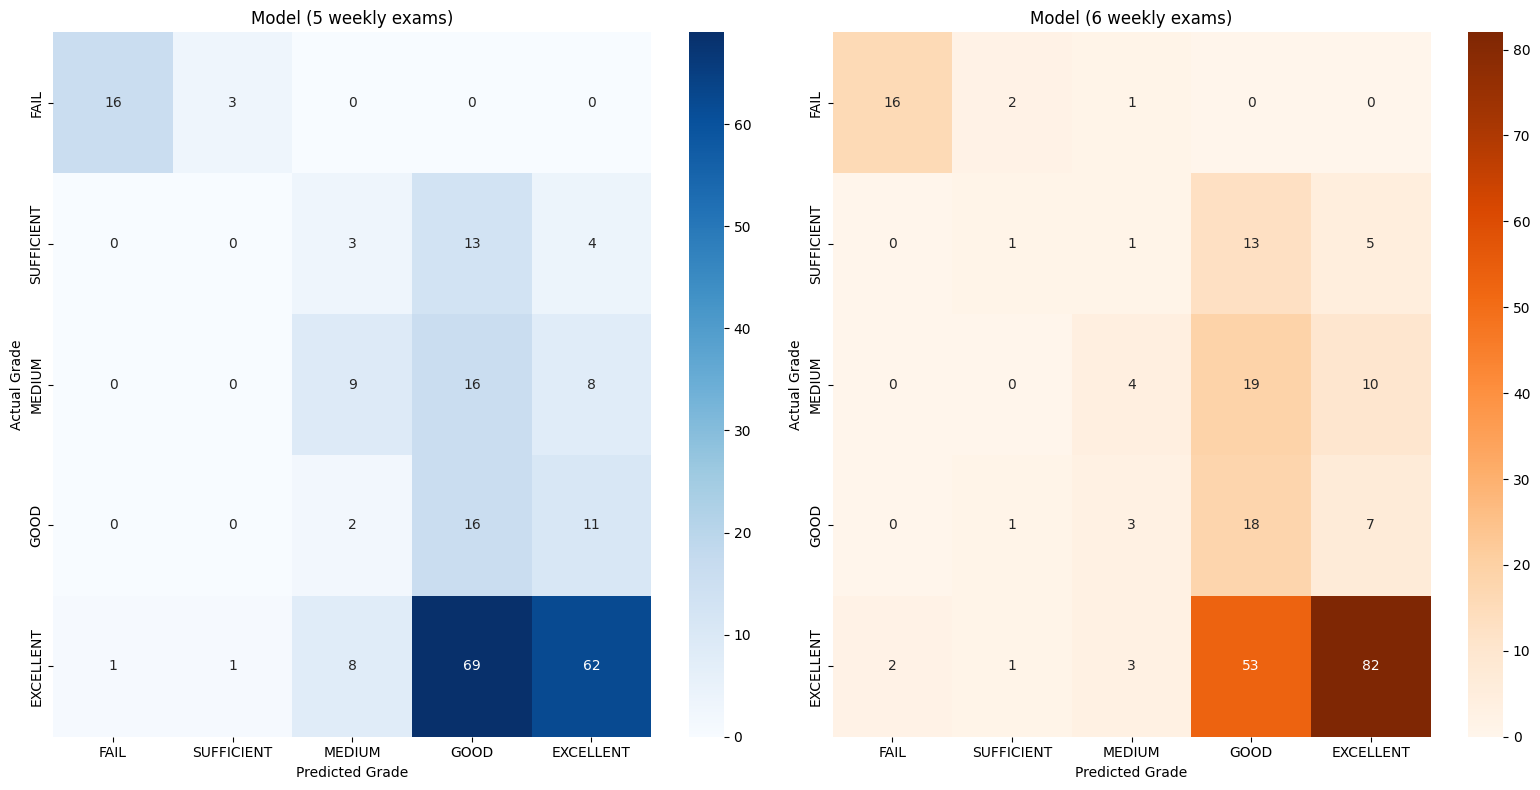

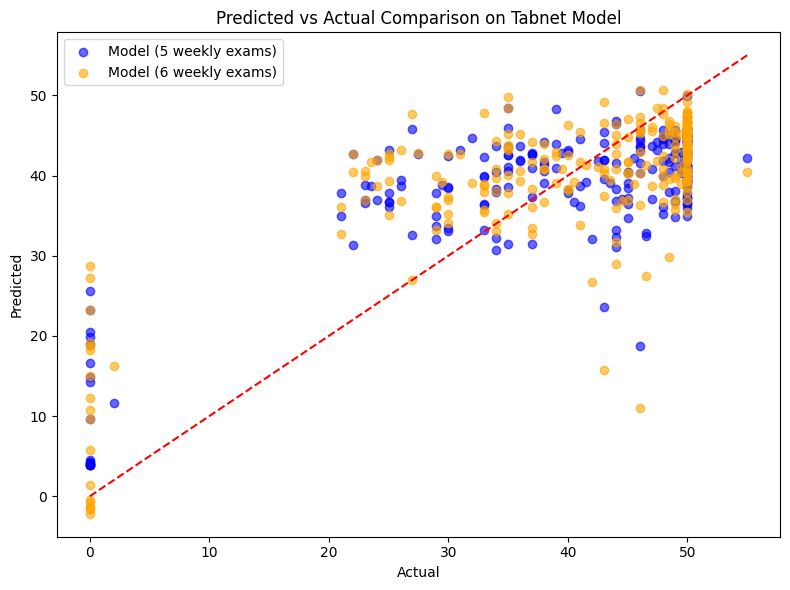

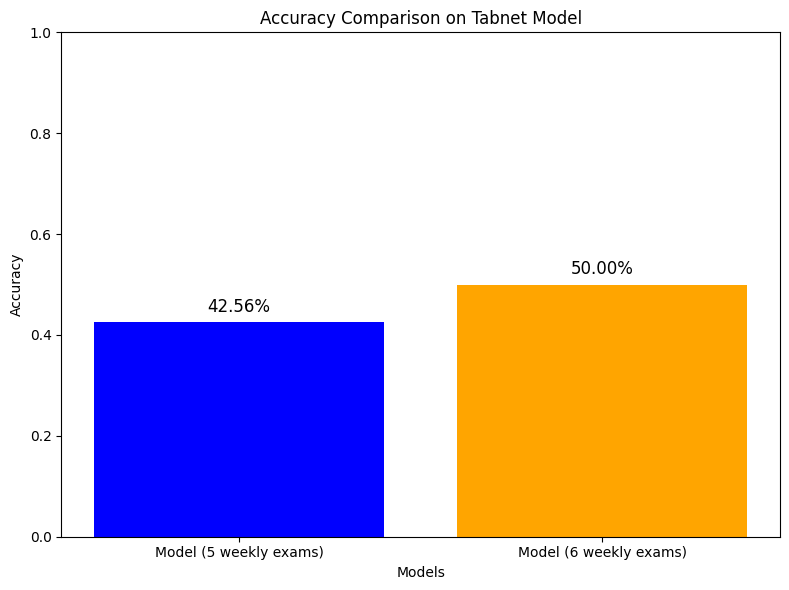

In [109]:
# Metrics calculation
tabnet_metrics_five = calculate_metrics(YFive_test, test_five_predictions.ravel())
tabnet_metrics_six = calculate_metrics(YSix_test, test_six_predictions.ravel())

metrics = ['MSE', 'RMSE', 'MAE', 'R²']

# Values for each model
tabnet_five_values = [tabnet_metrics_five["MSE"], tabnet_metrics_five["RMSE"], tabnet_metrics_five["MAE"], tabnet_metrics_five["R2"]]
tabnet_six_values = [tabnet_metrics_six["MSE"], tabnet_metrics_six["RMSE"], tabnet_metrics_six["MAE"], tabnet_metrics_six["R2"]]

# Plots
generate_metrics_comparison(tabnet_five_values, tabnet_six_values,"Metrics comparison on Tabnet Model")
generate_confusion_matrices(test_five_predictions.ravel(), test_six_predictions.ravel())
generate_predicted_vs_actual_comparison(YFive_test, test_five_predictions.ravel(), YSix_test, test_six_predictions.ravel(), "Predicted vs Actual Comparison on Tabnet Model")
generate_accuracy_comparison(tabnet_metrics_five["Accuracy"], tabnet_metrics_six["Accuracy"], "Accuracy Comparison on Tabnet Model")

**TabNetRegressor with best parameters**

In [91]:
def objective_five(trial):
    n_d = trial.suggest_int("n_d", 16, 64)
    n_a = trial.suggest_int("n_a", 16, 64)
    n_steps = trial.suggest_int("n_steps", 5, 10)
    lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
    momentum = trial.suggest_uniform("momentum", 0.3, 0.7)
    gamma = trial.suggest_uniform("gamma", 1.0, 2.0)
    mask_type = trial.suggest_categorical("mask_type", ["sparsemax", "entmax"])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)
    dropout = trial.suggest_uniform("dropout", 0.0, 0.3)

    model = TabNetRegressor(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        lambda_sparse=lambda_sparse,
        momentum=momentum,
        gamma=gamma,
        mask_type=mask_type
    )

    model.fit(
        X_train_five_scaled, y_five_train,
        eval_set=[(X_val_five_scaled, y_five_val)],
        max_epochs=50,
        patience=10,
        batch_size=32,
        virtual_batch_size=32,
        drop_last=False,
        from_unsupervised=None
    )

    predictions = model.predict(X_test_five_scaled)
    mse = mean_squared_error(y_five_test, predictions)

    return mse

def objective_six(trial):
    n_d = trial.suggest_int("n_d", 16, 64)
    n_a = trial.suggest_int("n_a", 16, 64)
    n_steps = trial.suggest_int("n_steps", 5, 10)
    lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
    momentum = trial.suggest_uniform("momentum", 0.3, 0.7)
    gamma = trial.suggest_uniform("gamma", 1.0, 2.0)
    mask_type = trial.suggest_categorical("mask_type", ["sparsemax", "entmax"])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)
    dropout = trial.suggest_uniform("dropout", 0.0, 0.3)

    model = TabNetRegressor(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        lambda_sparse=lambda_sparse,
        momentum=momentum,
        gamma=gamma,
        mask_type=mask_type
    )

    model.fit(
        X_train_six_scaled, y_six_train,
        eval_set=[(X_val_six_scaled, y_six_val)],
        max_epochs=50,
        patience=10,
        batch_size=32,
        virtual_batch_size=32,
        drop_last=False,
        from_unsupervised=None
    )

    predictions = model.predict(X_test_six_scaled)
    mse = mean_squared_error(y_six_test, predictions)

    return mse

study_five = optuna.create_study(direction="minimize")
study_five.optimize(objective_five, n_trials=15)

study_six = optuna.create_study(direction="minimize")
study_six.optimize(objective_six, n_trials=15)

print("Best Hyperparameters model with 5 weekly exam:", study_five.best_params)
print("Best Hyperparameters model with 6 weekly exam:", study_six.best_params)

best_params_five = study_five.best_params
tabnet_best_five = TabNetRegressor(
    n_d=best_params_five["n_d"],
    n_a=best_params_five["n_a"],
    n_steps=best_params_five["n_steps"],
    lambda_sparse=best_params_five["lambda_sparse"],
    momentum=best_params_five["momentum"],
    gamma=best_params_five["gamma"],
    mask_type=best_params_five["mask_type"]
)

best_params_six = study_six.best_params
tabnet_best_six = TabNetRegressor(
    n_d=best_params_six["n_d"],
    n_a=best_params_six["n_a"],
    n_steps=best_params_six["n_steps"],
    lambda_sparse=best_params_six["lambda_sparse"],
    momentum=best_params_six["momentum"],
    gamma=best_params_six["gamma"],
    mask_type=best_params_six["mask_type"]
)

tabnet_best_five.fit(
    X_train_five_scaled, y_five_train,
    eval_set=[(X_val_five_scaled, y_five_val)],
    max_epochs=100,
    patience=15,
    batch_size=32,
    virtual_batch_size=32,
    drop_last=False,
    from_unsupervised=None
)

tabnet_best_six.fit(
    X_train_six_scaled, y_six_train,
    eval_set=[(X_val_six_scaled, y_six_val)],
    max_epochs=100,
    patience=15,
    batch_size=32,
    virtual_batch_size=32,
    drop_last=False,
    from_unsupervised=None
)

final_predictions_five = tabnet_best_five.predict(X_test_five_scaled)
final_predictions_six = tabnet_best_six.predict(X_test_six_scaled)

#torch.save(tabnet_best_six, "tabnet_best_six.pth")

[I 2025-04-02 19:50:07,247] A new study created in memory with name: no-name-a3d15aa9-3769-483d-b3aa-78e377c00417
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform("momentum", 0.3, 0.7)
<ipython-input-91-788b8da119ba>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 1.0, 2.0)
<ipython-input-91-788b

epoch 0  | loss: 415.65841| val_0_mse: 124.33238|  0:00:01s
epoch 1  | loss: 115.18708| val_0_mse: 119.43824|  0:00:02s
epoch 2  | loss: 118.0538| val_0_mse: 110.65125|  0:00:03s
epoch 3  | loss: 101.92637| val_0_mse: 90.79555|  0:00:04s
epoch 4  | loss: 108.05373| val_0_mse: 84.83892|  0:00:05s
epoch 5  | loss: 90.88584| val_0_mse: 82.08565|  0:00:06s
epoch 6  | loss: 93.97717| val_0_mse: 75.4798 |  0:00:07s
epoch 7  | loss: 92.33622| val_0_mse: 96.99636|  0:00:08s
epoch 8  | loss: 94.17811| val_0_mse: 98.26846|  0:00:09s
epoch 9  | loss: 92.6016 | val_0_mse: 78.61845|  0:00:10s
epoch 10 | loss: 81.66242| val_0_mse: 80.15445|  0:00:11s
epoch 11 | loss: 81.59545| val_0_mse: 120.63602|  0:00:12s
epoch 12 | loss: 86.13753| val_0_mse: 71.53358|  0:00:13s
epoch 13 | loss: 82.46502| val_0_mse: 80.18917|  0:00:15s
epoch 14 | loss: 84.48081| val_0_mse: 91.49292|  0:00:16s
epoch 15 | loss: 85.54144| val_0_mse: 81.49986|  0:00:17s
epoch 16 | loss: 86.11198| val_0_mse: 91.03229|  0:00:18s
epoch 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:50:46,689] Trial 0 finished with value: 87.12770080566406 and parameters: {'n_d': 58, 'n_a': 29, 'n_steps': 6, 'lambda_sparse': 1.667272997177685e-05, 'momentum': 0.4166402856703846, 'gamma': 1.225649170584317, 'mask_type': 'sparsemax', 'learning_rate': 0.016900911048134574, 'dropout': 0.04934925877626577}. Best is trial 0 with value: 87.12770080566406.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

epoch 0  | loss: 655.26005| val_0_mse: 201.09874|  0:00:01s
epoch 1  | loss: 145.03497| val_0_mse: 127.7718|  0:00:02s
epoch 2  | loss: 109.73943| val_0_mse: 92.56213|  0:00:03s
epoch 3  | loss: 99.34961| val_0_mse: 96.43089|  0:00:04s
epoch 4  | loss: 105.82625| val_0_mse: 85.24371|  0:00:06s
epoch 5  | loss: 98.58926| val_0_mse: 75.3452 |  0:00:07s
epoch 6  | loss: 99.8887 | val_0_mse: 81.19785|  0:00:08s
epoch 7  | loss: 100.81646| val_0_mse: 81.84612|  0:00:09s
epoch 8  | loss: 102.57306| val_0_mse: 84.88048|  0:00:11s
epoch 9  | loss: 97.93632| val_0_mse: 91.53694|  0:00:12s
epoch 10 | loss: 95.23032| val_0_mse: 74.34761|  0:00:13s
epoch 11 | loss: 91.46132| val_0_mse: 82.57021|  0:00:14s
epoch 12 | loss: 92.03647| val_0_mse: 67.45731|  0:00:16s
epoch 13 | loss: 83.93993| val_0_mse: 76.37993|  0:00:17s
epoch 14 | loss: 85.21168| val_0_mse: 65.80987|  0:00:18s
epoch 15 | loss: 86.86045| val_0_mse: 72.25278|  0:00:19s
epoch 16 | loss: 82.56343| val_0_mse: 68.27599|  0:00:20s
epoch 1

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:51:29,284] Trial 1 finished with value: 84.4315414428711 and parameters: {'n_d': 34, 'n_a': 37, 'n_steps': 7, 'lambda_sparse': 9.023010941110025e-05, 'momentum': 0.49000507377373204, 'gamma': 1.4317616026422737, 'mask_type': 'sparsemax', 'learning_rate': 0.03868061127674961, 'dropout': 0.15429321363178877}. Best is trial 1 with value: 84.4315414428711.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

epoch 0  | loss: 746.35654| val_0_mse: 158.88882|  0:00:01s
epoch 1  | loss: 118.60391| val_0_mse: 76.05962|  0:00:02s
epoch 2  | loss: 94.58651| val_0_mse: 72.59222|  0:00:03s
epoch 3  | loss: 92.94681| val_0_mse: 99.53211|  0:00:04s
epoch 4  | loss: 85.37005| val_0_mse: 92.9197 |  0:00:05s
epoch 5  | loss: 92.77584| val_0_mse: 82.20518|  0:00:06s
epoch 6  | loss: 89.65581| val_0_mse: 83.60767|  0:00:07s
epoch 7  | loss: 75.24722| val_0_mse: 81.71564|  0:00:08s
epoch 8  | loss: 81.7025 | val_0_mse: 83.38656|  0:00:10s
epoch 9  | loss: 83.73804| val_0_mse: 94.8463 |  0:00:11s
epoch 10 | loss: 96.30827| val_0_mse: 69.11313|  0:00:12s
epoch 11 | loss: 86.83045| val_0_mse: 99.82647|  0:00:13s
epoch 12 | loss: 79.31069| val_0_mse: 80.24387|  0:00:14s
epoch 13 | loss: 81.39147| val_0_mse: 73.57011|  0:00:15s
epoch 14 | loss: 78.44618| val_0_mse: 75.09295|  0:00:16s
epoch 15 | loss: 70.99109| val_0_mse: 77.82553|  0:00:17s
epoch 16 | loss: 76.29758| val_0_mse: 104.19429|  0:00:18s
epoch 17 |

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:51:53,157] Trial 2 finished with value: 102.72590637207031 and parameters: {'n_d': 54, 'n_a': 19, 'n_steps': 6, 'lambda_sparse': 6.574970809746128e-05, 'momentum': 0.667930683772975, 'gamma': 1.3422007765192823, 'mask_type': 'entmax', 'learning_rate': 0.07298269890727797, 'dropout': 0.0575158538452511}. Best is trial 1 with value: 84.4315414428711.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.

epoch 0  | loss: 717.54405| val_0_mse: 223.74187|  0:00:00s
epoch 1  | loss: 143.70815| val_0_mse: 99.60972|  0:00:01s
epoch 2  | loss: 96.04143| val_0_mse: 78.69711|  0:00:02s
epoch 3  | loss: 94.47005| val_0_mse: 90.3559 |  0:00:03s
epoch 4  | loss: 84.06957| val_0_mse: 92.93355|  0:00:04s
epoch 5  | loss: 108.79515| val_0_mse: 76.35903|  0:00:05s
epoch 6  | loss: 97.1664 | val_0_mse: 103.46292|  0:00:06s
epoch 7  | loss: 93.01335| val_0_mse: 117.24824|  0:00:07s
epoch 8  | loss: 85.52944| val_0_mse: 74.99187|  0:00:08s
epoch 9  | loss: 86.16852| val_0_mse: 68.38775|  0:00:09s
epoch 10 | loss: 78.63376| val_0_mse: 75.56355|  0:00:10s
epoch 11 | loss: 78.92146| val_0_mse: 66.34397|  0:00:11s
epoch 12 | loss: 73.46095| val_0_mse: 72.14828|  0:00:12s
epoch 13 | loss: 74.79088| val_0_mse: 78.76637|  0:00:13s
epoch 14 | loss: 84.10506| val_0_mse: 83.22924|  0:00:14s
epoch 15 | loss: 76.76972| val_0_mse: 78.80978|  0:00:15s
epoch 16 | loss: 75.49032| val_0_mse: 72.22437|  0:00:16s
epoch 17

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:52:14,455] Trial 3 finished with value: 109.87712097167969 and parameters: {'n_d': 34, 'n_a': 21, 'n_steps': 5, 'lambda_sparse': 2.8100249592075986e-05, 'momentum': 0.618961051513825, 'gamma': 1.5326520018481242, 'mask_type': 'entmax', 'learning_rate': 0.0017468451326030372, 'dropout': 0.05347385830083906}. Best is trial 1 with value: 84.4315414428711.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

epoch 0  | loss: 418.2545| val_0_mse: 120.48648|  0:00:01s
epoch 1  | loss: 118.25228| val_0_mse: 104.81005|  0:00:03s
epoch 2  | loss: 103.43707| val_0_mse: 102.61987|  0:00:05s
epoch 3  | loss: 97.55794| val_0_mse: 78.16633|  0:00:06s
epoch 4  | loss: 90.53971| val_0_mse: 96.37907|  0:00:08s
epoch 5  | loss: 84.21608| val_0_mse: 101.42328|  0:00:10s
epoch 6  | loss: 87.47644| val_0_mse: 63.68132|  0:00:12s
epoch 7  | loss: 82.52464| val_0_mse: 77.06148|  0:00:13s
epoch 8  | loss: 78.07251| val_0_mse: 81.26001|  0:00:15s
epoch 9  | loss: 71.94021| val_0_mse: 88.65012|  0:00:17s
epoch 10 | loss: 78.72514| val_0_mse: 62.65833|  0:00:19s
epoch 11 | loss: 75.19237| val_0_mse: 76.71209|  0:00:20s
epoch 12 | loss: 79.22336| val_0_mse: 82.64719|  0:00:22s
epoch 13 | loss: 72.25246| val_0_mse: 69.85548|  0:00:24s
epoch 14 | loss: 77.34671| val_0_mse: 86.47517|  0:00:26s
epoch 15 | loss: 85.83554| val_0_mse: 77.3177 |  0:00:27s
epoch 16 | loss: 73.55009| val_0_mse: 71.99013|  0:00:29s
epoch 17

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:52:51,777] Trial 4 finished with value: 86.30265045166016 and parameters: {'n_d': 54, 'n_a': 43, 'n_steps': 10, 'lambda_sparse': 1.924606310903853e-05, 'momentum': 0.5693898833502302, 'gamma': 1.011286551522231, 'mask_type': 'entmax', 'learning_rate': 0.014440912866659144, 'dropout': 0.19438152226377614}. Best is trial 1 with value: 84.4315414428711.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://githu

epoch 0  | loss: 777.73202| val_0_mse: 271.75406|  0:00:01s
epoch 1  | loss: 160.14149| val_0_mse: 163.53708|  0:00:03s
epoch 2  | loss: 115.93912| val_0_mse: 86.83395|  0:00:04s
epoch 3  | loss: 106.5642| val_0_mse: 109.12318|  0:00:06s
epoch 4  | loss: 105.54216| val_0_mse: 103.83777|  0:00:07s
epoch 5  | loss: 100.80478| val_0_mse: 107.67701|  0:00:09s
epoch 6  | loss: 100.18627| val_0_mse: 90.26611|  0:00:10s
epoch 7  | loss: 94.52411| val_0_mse: 101.49331|  0:00:12s
epoch 8  | loss: 101.70623| val_0_mse: 86.54191|  0:00:13s
epoch 9  | loss: 95.95677| val_0_mse: 74.1741 |  0:00:15s
epoch 10 | loss: 86.57476| val_0_mse: 80.46719|  0:00:16s
epoch 11 | loss: 97.48787| val_0_mse: 97.4138 |  0:00:18s
epoch 12 | loss: 92.03767| val_0_mse: 88.49026|  0:00:19s
epoch 13 | loss: 89.3636 | val_0_mse: 78.30219|  0:00:21s
epoch 14 | loss: 84.20955| val_0_mse: 74.94009|  0:00:22s
epoch 15 | loss: 80.29055| val_0_mse: 66.9953 |  0:00:24s
epoch 16 | loss: 89.97871| val_0_mse: 64.51163|  0:00:25s
e

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:53:35,336] Trial 5 finished with value: 84.6304931640625 and parameters: {'n_d': 17, 'n_a': 23, 'n_steps': 9, 'lambda_sparse': 6.484837521170827e-05, 'momentum': 0.5256952681364818, 'gamma': 1.6708268380872031, 'mask_type': 'sparsemax', 'learning_rate': 0.005453133493912422, 'dropout': 0.2810064090937869}. Best is trial 1 with value: 84.4315414428711.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gith

epoch 0  | loss: 556.83003| val_0_mse: 197.82777|  0:00:01s
epoch 1  | loss: 144.00641| val_0_mse: 77.42617|  0:00:02s
epoch 2  | loss: 124.0192| val_0_mse: 86.89025|  0:00:03s
epoch 3  | loss: 111.83362| val_0_mse: 97.55001|  0:00:04s
epoch 4  | loss: 108.40921| val_0_mse: 93.41474|  0:00:05s
epoch 5  | loss: 106.08732| val_0_mse: 86.30626|  0:00:06s
epoch 6  | loss: 88.41773| val_0_mse: 75.60887|  0:00:07s
epoch 7  | loss: 93.78097| val_0_mse: 81.98547|  0:00:08s
epoch 8  | loss: 87.19804| val_0_mse: 85.89221|  0:00:09s
epoch 9  | loss: 92.05968| val_0_mse: 85.34271|  0:00:10s
epoch 10 | loss: 86.10142| val_0_mse: 99.03376|  0:00:11s
epoch 11 | loss: 78.93652| val_0_mse: 72.25958|  0:00:13s
epoch 12 | loss: 88.65329| val_0_mse: 77.73967|  0:00:14s
epoch 13 | loss: 87.60741| val_0_mse: 72.53967|  0:00:15s
epoch 14 | loss: 84.93546| val_0_mse: 102.33136|  0:00:16s
epoch 15 | loss: 88.22776| val_0_mse: 97.7254 |  0:00:17s
epoch 16 | loss: 80.76202| val_0_mse: 87.88868|  0:00:18s
epoch 1

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:54:12,854] Trial 6 finished with value: 94.43632507324219 and parameters: {'n_d': 48, 'n_a': 34, 'n_steps': 6, 'lambda_sparse': 5.805458273955058e-05, 'momentum': 0.3482599007968789, 'gamma': 1.9235651344622986, 'mask_type': 'sparsemax', 'learning_rate': 0.003981288300264266, 'dropout': 0.12918829394315287}. Best is trial 1 with value: 84.4315414428711.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

epoch 0  | loss: 639.40418| val_0_mse: 175.28261|  0:00:01s
epoch 1  | loss: 136.82239| val_0_mse: 100.33928|  0:00:02s
epoch 2  | loss: 114.78899| val_0_mse: 104.24419|  0:00:03s
epoch 3  | loss: 99.24622| val_0_mse: 109.13724|  0:00:04s
epoch 4  | loss: 103.45034| val_0_mse: 85.83546|  0:00:06s
epoch 5  | loss: 91.91748| val_0_mse: 87.20428|  0:00:07s
epoch 6  | loss: 91.81184| val_0_mse: 81.97437|  0:00:08s
epoch 7  | loss: 88.84236| val_0_mse: 77.69466|  0:00:09s
epoch 8  | loss: 91.46022| val_0_mse: 82.46888|  0:00:10s
epoch 9  | loss: 90.42662| val_0_mse: 85.97414|  0:00:12s
epoch 10 | loss: 83.84773| val_0_mse: 82.51588|  0:00:13s
epoch 11 | loss: 83.71073| val_0_mse: 71.61626|  0:00:14s
epoch 12 | loss: 87.43608| val_0_mse: 133.95244|  0:00:15s
epoch 13 | loss: 94.19506| val_0_mse: 77.68998|  0:00:17s
epoch 14 | loss: 89.92056| val_0_mse: 76.42235|  0:00:18s
epoch 15 | loss: 84.45092| val_0_mse: 69.2371 |  0:00:19s
epoch 16 | loss: 83.45009| val_0_mse: 69.50277|  0:00:20s
epoch

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:54:49,954] Trial 7 finished with value: 80.51204681396484 and parameters: {'n_d': 22, 'n_a': 49, 'n_steps': 7, 'lambda_sparse': 3.3929944809956495e-05, 'momentum': 0.49625917762404537, 'gamma': 1.3472825916757771, 'mask_type': 'sparsemax', 'learning_rate': 0.011786542351188912, 'dropout': 0.2792218930388866}. Best is trial 7 with value: 80.51204681396484.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

epoch 0  | loss: 627.58113| val_0_mse: 199.10498|  0:00:00s
epoch 1  | loss: 126.28641| val_0_mse: 84.5063 |  0:00:01s
epoch 2  | loss: 93.82881| val_0_mse: 96.64355|  0:00:02s
epoch 3  | loss: 97.29363| val_0_mse: 106.46325|  0:00:03s
epoch 4  | loss: 91.10802| val_0_mse: 93.54167|  0:00:04s
epoch 5  | loss: 91.92719| val_0_mse: 87.07725|  0:00:05s
epoch 6  | loss: 89.71914| val_0_mse: 79.27739|  0:00:06s
epoch 7  | loss: 93.60415| val_0_mse: 77.90364|  0:00:07s
epoch 8  | loss: 80.28942| val_0_mse: 73.75614|  0:00:08s
epoch 9  | loss: 83.86029| val_0_mse: 80.93345|  0:00:09s
epoch 10 | loss: 79.27864| val_0_mse: 82.88435|  0:00:10s
epoch 11 | loss: 76.97788| val_0_mse: 72.75488|  0:00:10s
epoch 12 | loss: 83.99948| val_0_mse: 68.46416|  0:00:11s
epoch 13 | loss: 73.29994| val_0_mse: 89.67333|  0:00:12s
epoch 14 | loss: 79.37463| val_0_mse: 71.09206|  0:00:13s
epoch 15 | loss: 83.61563| val_0_mse: 75.44536|  0:00:14s
epoch 16 | loss: 81.91716| val_0_mse: 74.33571|  0:00:15s
epoch 17 |

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:55:11,398] Trial 8 finished with value: 91.89376831054688 and parameters: {'n_d': 24, 'n_a': 23, 'n_steps': 5, 'lambda_sparse': 1.864161152381054e-05, 'momentum': 0.5832863360765239, 'gamma': 1.844703529618687, 'mask_type': 'sparsemax', 'learning_rate': 0.002853118595318027, 'dropout': 0.2568967938314112}. Best is trial 7 with value: 80.51204681396484.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

epoch 0  | loss: 435.91422| val_0_mse: 113.79502|  0:00:01s
epoch 1  | loss: 120.05456| val_0_mse: 119.87679|  0:00:02s
epoch 2  | loss: 110.57023| val_0_mse: 98.75883|  0:00:03s
epoch 3  | loss: 105.23769| val_0_mse: 75.47723|  0:00:04s
epoch 4  | loss: 101.84645| val_0_mse: 106.26773|  0:00:06s
epoch 5  | loss: 97.73462| val_0_mse: 78.52443|  0:00:07s
epoch 6  | loss: 104.08996| val_0_mse: 92.42165|  0:00:08s
epoch 7  | loss: 92.87276| val_0_mse: 83.57946|  0:00:09s
epoch 8  | loss: 82.73699| val_0_mse: 75.62804|  0:00:11s
epoch 9  | loss: 83.80057| val_0_mse: 76.46823|  0:00:12s
epoch 10 | loss: 83.24184| val_0_mse: 80.30469|  0:00:13s
epoch 11 | loss: 85.71852| val_0_mse: 73.85057|  0:00:14s
epoch 12 | loss: 77.38855| val_0_mse: 75.96259|  0:00:15s
epoch 13 | loss: 86.72849| val_0_mse: 70.58792|  0:00:17s
epoch 14 | loss: 88.02864| val_0_mse: 73.62399|  0:00:18s
epoch 15 | loss: 78.9063 | val_0_mse: 70.95645|  0:00:19s
epoch 16 | loss: 81.97242| val_0_mse: 89.23641|  0:00:20s
epoch

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:55:57,574] Trial 9 finished with value: 72.85228729248047 and parameters: {'n_d': 48, 'n_a': 45, 'n_steps': 7, 'lambda_sparse': 1.9849643863446357e-05, 'momentum': 0.5109773162671165, 'gamma': 1.4350241594875208, 'mask_type': 'entmax', 'learning_rate': 0.0073667958737002985, 'dropout': 0.1988744458440302}. Best is trial 9 with value: 72.85228729248047.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

epoch 0  | loss: 517.06931| val_0_mse: 192.07716|  0:00:01s
epoch 1  | loss: 132.89563| val_0_mse: 115.37446|  0:00:03s
epoch 2  | loss: 107.44009| val_0_mse: 111.59245|  0:00:04s
epoch 3  | loss: 115.83216| val_0_mse: 92.37457|  0:00:05s
epoch 4  | loss: 113.65421| val_0_mse: 98.21931|  0:00:07s
epoch 5  | loss: 103.2086| val_0_mse: 71.74378|  0:00:08s
epoch 6  | loss: 102.11859| val_0_mse: 120.51752|  0:00:10s
epoch 7  | loss: 103.42644| val_0_mse: 87.22807|  0:00:11s
epoch 8  | loss: 89.58487| val_0_mse: 96.50031|  0:00:12s
epoch 9  | loss: 89.26969| val_0_mse: 88.19197|  0:00:14s
epoch 10 | loss: 98.7844 | val_0_mse: 66.50906|  0:00:15s
epoch 11 | loss: 93.72662| val_0_mse: 80.40215|  0:00:17s
epoch 12 | loss: 90.91774| val_0_mse: 67.82386|  0:00:18s
epoch 13 | loss: 82.79986| val_0_mse: 111.45811|  0:00:20s
epoch 14 | loss: 84.69213| val_0_mse: 70.28989|  0:00:21s
epoch 15 | loss: 87.3312 | val_0_mse: 72.55049|  0:00:22s
epoch 16 | loss: 87.65213| val_0_mse: 74.06384|  0:00:24s
ep

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:56:28,156] Trial 10 finished with value: 118.44109344482422 and parameters: {'n_d': 43, 'n_a': 64, 'n_steps': 8, 'lambda_sparse': 1.108928283434682e-05, 'momentum': 0.4190586831441375, 'gamma': 1.7023715237724, 'mask_type': 'entmax', 'learning_rate': 0.0011031497038157658, 'dropout': 0.20368948162189152}. Best is trial 9 with value: 72.85228729248047.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gith

epoch 0  | loss: 428.26489| val_0_mse: 164.82196|  0:00:01s
epoch 1  | loss: 128.33895| val_0_mse: 93.85429|  0:00:02s
epoch 2  | loss: 115.36916| val_0_mse: 85.64098|  0:00:04s
epoch 3  | loss: 101.87712| val_0_mse: 70.70087|  0:00:05s
epoch 4  | loss: 95.24268| val_0_mse: 72.55557|  0:00:07s
epoch 5  | loss: 98.7602 | val_0_mse: 68.35248|  0:00:08s
epoch 6  | loss: 88.25633| val_0_mse: 73.07877|  0:00:09s
epoch 7  | loss: 83.36905| val_0_mse: 84.72513|  0:00:11s
epoch 8  | loss: 84.07426| val_0_mse: 80.06934|  0:00:12s
epoch 9  | loss: 85.56586| val_0_mse: 80.44512|  0:00:14s
epoch 10 | loss: 86.57221| val_0_mse: 66.42421|  0:00:15s
epoch 11 | loss: 84.32631| val_0_mse: 76.08722|  0:00:16s
epoch 12 | loss: 80.36754| val_0_mse: 74.87296|  0:00:18s
epoch 13 | loss: 82.77956| val_0_mse: 68.87054|  0:00:19s
epoch 14 | loss: 81.27731| val_0_mse: 79.79922|  0:00:21s
epoch 15 | loss: 80.89831| val_0_mse: 73.84195|  0:00:22s
epoch 16 | loss: 77.89345| val_0_mse: 70.33312|  0:00:23s
epoch 17 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:57:18,121] Trial 11 finished with value: 88.2909164428711 and parameters: {'n_d': 29, 'n_a': 49, 'n_steps': 8, 'lambda_sparse': 3.6372390053785776e-05, 'momentum': 0.478744144361253, 'gamma': 1.1840608626930618, 'mask_type': 'entmax', 'learning_rate': 0.008272266094897287, 'dropout': 0.22725378621631342}. Best is trial 9 with value: 72.85228729248047.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gith

epoch 0  | loss: 457.40111| val_0_mse: 136.45789|  0:00:01s
epoch 1  | loss: 123.30069| val_0_mse: 142.38844|  0:00:02s
epoch 2  | loss: 109.0346| val_0_mse: 87.48214|  0:00:04s
epoch 3  | loss: 106.64713| val_0_mse: 89.08798|  0:00:05s
epoch 4  | loss: 107.95841| val_0_mse: 85.99379|  0:00:06s
epoch 5  | loss: 89.95697| val_0_mse: 93.20748|  0:00:07s
epoch 6  | loss: 92.30084| val_0_mse: 80.00962|  0:00:08s
epoch 7  | loss: 101.34374| val_0_mse: 92.90491|  0:00:10s
epoch 8  | loss: 92.75973| val_0_mse: 85.18653|  0:00:11s
epoch 9  | loss: 81.37017| val_0_mse: 85.41515|  0:00:12s
epoch 10 | loss: 88.11246| val_0_mse: 79.41609|  0:00:13s
epoch 11 | loss: 85.27181| val_0_mse: 78.64665|  0:00:15s
epoch 12 | loss: 81.02145| val_0_mse: 79.33938|  0:00:16s
epoch 13 | loss: 89.59531| val_0_mse: 75.93338|  0:00:17s
epoch 14 | loss: 83.85931| val_0_mse: 86.18142|  0:00:19s
epoch 15 | loss: 83.15636| val_0_mse: 95.26871|  0:00:20s
epoch 16 | loss: 82.82388| val_0_mse: 101.35014|  0:00:21s
epoch 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:57:54,133] Trial 12 finished with value: 85.7448501586914 and parameters: {'n_d': 63, 'n_a': 55, 'n_steps': 7, 'lambda_sparse': 3.3157970320309346e-05, 'momentum': 0.4243296581093809, 'gamma': 1.5499033959333572, 'mask_type': 'entmax', 'learning_rate': 0.023598173897511385, 'dropout': 0.29558650390445784}. Best is trial 9 with value: 72.85228729248047.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

epoch 0  | loss: 488.66873| val_0_mse: 269.99481|  0:00:01s
epoch 1  | loss: 122.35  | val_0_mse: 85.03214|  0:00:02s
epoch 2  | loss: 109.11545| val_0_mse: 124.92182|  0:00:03s
epoch 3  | loss: 109.2506| val_0_mse: 115.97274|  0:00:04s
epoch 4  | loss: 114.77927| val_0_mse: 92.8187 |  0:00:06s
epoch 5  | loss: 98.32268| val_0_mse: 80.23323|  0:00:07s
epoch 6  | loss: 96.46985| val_0_mse: 74.90474|  0:00:08s
epoch 7  | loss: 100.96532| val_0_mse: 102.59319|  0:00:09s
epoch 8  | loss: 88.73797| val_0_mse: 83.42049|  0:00:11s
epoch 9  | loss: 91.82552| val_0_mse: 88.00095|  0:00:12s
epoch 10 | loss: 96.78635| val_0_mse: 117.32939|  0:00:13s
epoch 11 | loss: 97.81429| val_0_mse: 89.55216|  0:00:14s
epoch 12 | loss: 105.93795| val_0_mse: 100.23916|  0:00:15s
epoch 13 | loss: 90.15933| val_0_mse: 76.07185|  0:00:17s
epoch 14 | loss: 77.89657| val_0_mse: 77.96105|  0:00:18s
epoch 15 | loss: 79.199  | val_0_mse: 68.70729|  0:00:19s
epoch 16 | loss: 91.62853| val_0_mse: 70.40038|  0:00:20s
epo

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:58:32,872] Trial 13 finished with value: 82.24308776855469 and parameters: {'n_d': 42, 'n_a': 49, 'n_steps': 7, 'lambda_sparse': 2.8473589989326772e-05, 'momentum': 0.3284448788519617, 'gamma': 1.3126913825711963, 'mask_type': 'sparsemax', 'learning_rate': 0.008908616383801488, 'dropout': 0.14466466139754727}. Best is trial 9 with value: 72.85228729248047.
<ipython-input-91-788b8da119ba>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:/

epoch 0  | loss: 947.53998| val_0_mse: 209.94736|  0:00:01s
epoch 1  | loss: 150.23765| val_0_mse: 95.23765|  0:00:03s
epoch 2  | loss: 114.22491| val_0_mse: 109.51654|  0:00:04s
epoch 3  | loss: 102.12291| val_0_mse: 81.12947|  0:00:06s
epoch 4  | loss: 99.74411| val_0_mse: 85.4044 |  0:00:07s
epoch 5  | loss: 95.18684| val_0_mse: 76.75641|  0:00:09s
epoch 6  | loss: 83.92683| val_0_mse: 85.59542|  0:00:10s
epoch 7  | loss: 78.19569| val_0_mse: 102.25327|  0:00:12s
epoch 8  | loss: 91.50804| val_0_mse: 75.76892|  0:00:13s
epoch 9  | loss: 97.90395| val_0_mse: 77.84092|  0:00:15s
epoch 10 | loss: 87.06313| val_0_mse: 75.95947|  0:00:16s
epoch 11 | loss: 89.21058| val_0_mse: 75.62029|  0:00:18s
epoch 12 | loss: 91.66823| val_0_mse: 83.16521|  0:00:19s
epoch 13 | loss: 88.91494| val_0_mse: 72.98117|  0:00:21s
epoch 14 | loss: 82.92029| val_0_mse: 70.65761|  0:00:23s
epoch 15 | loss: 86.14702| val_0_mse: 83.84352|  0:00:24s
epoch 16 | loss: 85.2158 | val_0_mse: 84.11163|  0:00:26s
epoch 1

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 19:59:50,358] Trial 14 finished with value: 83.93231201171875 and parameters: {'n_d': 17, 'n_a': 44, 'n_steps': 9, 'lambda_sparse': 4.3173671039061673e-05, 'momentum': 0.5303934237219609, 'gamma': 1.117649244957365, 'mask_type': 'sparsemax', 'learning_rate': 0.03262176219806884, 'dropout': 0.24388403184288932}. Best is trial 9 with value: 72.85228729248047.
[I 2025-04-02 19:59:50,359] A new study created in memory with name: no-name-f15335f0-83ea-4742-9471-2491f1b4181e
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43:

epoch 0  | loss: 607.03935| val_0_mse: 137.90793|  0:00:01s
epoch 1  | loss: 130.54239| val_0_mse: 95.87463|  0:00:03s
epoch 2  | loss: 117.73388| val_0_mse: 83.97987|  0:00:04s
epoch 3  | loss: 119.43902| val_0_mse: 131.35413|  0:00:06s
epoch 4  | loss: 104.35107| val_0_mse: 91.35101|  0:00:07s
epoch 5  | loss: 106.87403| val_0_mse: 83.12745|  0:00:09s
epoch 6  | loss: 103.73189| val_0_mse: 92.49796|  0:00:10s
epoch 7  | loss: 93.21279| val_0_mse: 82.05438|  0:00:12s
epoch 8  | loss: 95.43829| val_0_mse: 77.59315|  0:00:13s
epoch 9  | loss: 96.47044| val_0_mse: 106.42902|  0:00:15s
epoch 10 | loss: 92.88312| val_0_mse: 85.09006|  0:00:16s
epoch 11 | loss: 99.81502| val_0_mse: 67.58873|  0:00:18s
epoch 12 | loss: 85.65631| val_0_mse: 61.25297|  0:00:19s
epoch 13 | loss: 84.40271| val_0_mse: 60.54503|  0:00:21s
epoch 14 | loss: 83.55646| val_0_mse: 65.01434|  0:00:22s
epoch 15 | loss: 89.28216| val_0_mse: 73.68597|  0:00:24s
epoch 16 | loss: 88.9919 | val_0_mse: 64.06174|  0:00:26s
epoc

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:00:27,877] Trial 0 finished with value: 92.49137878417969 and parameters: {'n_d': 61, 'n_a': 24, 'n_steps': 9, 'lambda_sparse': 7.510579900198215e-05, 'momentum': 0.5838872246031434, 'gamma': 1.3075844489690245, 'mask_type': 'sparsemax', 'learning_rate': 0.007666784560479142, 'dropout': 0.03405473554325001}. Best is trial 0 with value: 92.49137878417969.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:/

epoch 0  | loss: 644.9561| val_0_mse: 126.69663|  0:00:01s
epoch 1  | loss: 120.07932| val_0_mse: 96.82245|  0:00:03s
epoch 2  | loss: 119.48535| val_0_mse: 103.6669|  0:00:05s
epoch 3  | loss: 97.21919| val_0_mse: 87.58955|  0:00:06s
epoch 4  | loss: 107.32993| val_0_mse: 97.41659|  0:00:08s
epoch 5  | loss: 98.50691| val_0_mse: 81.35535|  0:00:10s
epoch 6  | loss: 92.10957| val_0_mse: 89.97946|  0:00:12s
epoch 7  | loss: 84.82715| val_0_mse: 70.27544|  0:00:13s
epoch 8  | loss: 86.61919| val_0_mse: 90.44701|  0:00:15s
epoch 9  | loss: 91.9279 | val_0_mse: 67.94521|  0:00:17s
epoch 10 | loss: 94.16815| val_0_mse: 87.2838 |  0:00:18s
epoch 11 | loss: 97.89857| val_0_mse: 70.62975|  0:00:20s
epoch 12 | loss: 80.9158 | val_0_mse: 75.58049|  0:00:22s
epoch 13 | loss: 79.46209| val_0_mse: 85.8256 |  0:00:24s
epoch 14 | loss: 76.79823| val_0_mse: 75.0154 |  0:00:25s
epoch 15 | loss: 82.63314| val_0_mse: 86.87257|  0:00:27s
epoch 16 | loss: 83.17967| val_0_mse: 73.81661|  0:00:29s
epoch 17 |

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:01:02,944] Trial 1 finished with value: 82.53799438476562 and parameters: {'n_d': 16, 'n_a': 47, 'n_steps': 10, 'lambda_sparse': 7.124485703249914e-05, 'momentum': 0.5102389815896878, 'gamma': 1.8595182559136565, 'mask_type': 'sparsemax', 'learning_rate': 0.020651405412052383, 'dropout': 0.020528359090217652}. Best is trial 1 with value: 82.53799438476562.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https

epoch 0  | loss: 566.7972| val_0_mse: 297.58121|  0:00:00s
epoch 1  | loss: 143.53814| val_0_mse: 124.86638|  0:00:01s
epoch 2  | loss: 140.00823| val_0_mse: 127.97285|  0:00:02s
epoch 3  | loss: 124.98649| val_0_mse: 103.47935|  0:00:03s
epoch 4  | loss: 102.59471| val_0_mse: 88.51734|  0:00:04s
epoch 5  | loss: 96.38095| val_0_mse: 92.77156|  0:00:05s
epoch 6  | loss: 88.49095| val_0_mse: 105.5672|  0:00:06s
epoch 7  | loss: 91.84509| val_0_mse: 87.08031|  0:00:07s
epoch 8  | loss: 86.54991| val_0_mse: 83.75421|  0:00:08s
epoch 9  | loss: 91.79662| val_0_mse: 108.74945|  0:00:09s
epoch 10 | loss: 96.60905| val_0_mse: 89.62206|  0:00:10s
epoch 11 | loss: 91.58349| val_0_mse: 82.83975|  0:00:11s
epoch 12 | loss: 86.5909 | val_0_mse: 100.84798|  0:00:12s
epoch 13 | loss: 84.83593| val_0_mse: 86.4663 |  0:00:12s
epoch 14 | loss: 86.43603| val_0_mse: 74.4269 |  0:00:13s
epoch 15 | loss: 80.18953| val_0_mse: 68.10779|  0:00:14s
epoch 16 | loss: 76.96012| val_0_mse: 68.84289|  0:00:15s
epoc

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:01:29,401] Trial 2 finished with value: 79.71134948730469 and parameters: {'n_d': 50, 'n_a': 52, 'n_steps': 5, 'lambda_sparse': 9.734975409925858e-05, 'momentum': 0.6345615680174563, 'gamma': 1.5785027256225463, 'mask_type': 'sparsemax', 'learning_rate': 0.09504891386650734, 'dropout': 0.17177175382065238}. Best is trial 2 with value: 79.71134948730469.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

epoch 0  | loss: 902.56894| val_0_mse: 331.5907|  0:00:01s
epoch 1  | loss: 220.4229| val_0_mse: 145.75987|  0:00:03s
epoch 2  | loss: 141.07395| val_0_mse: 100.95676|  0:00:05s
epoch 3  | loss: 118.18906| val_0_mse: 104.75547|  0:00:06s
epoch 4  | loss: 104.60318| val_0_mse: 88.51776|  0:00:08s
epoch 5  | loss: 107.47815| val_0_mse: 88.38534|  0:00:10s
epoch 6  | loss: 86.73168| val_0_mse: 171.79973|  0:00:11s
epoch 7  | loss: 88.01491| val_0_mse: 113.96558|  0:00:13s
epoch 8  | loss: 120.90858| val_0_mse: 82.33461|  0:00:15s
epoch 9  | loss: 85.10952| val_0_mse: 86.44363|  0:00:16s
epoch 10 | loss: 90.35764| val_0_mse: 74.43201|  0:00:18s
epoch 11 | loss: 82.46606| val_0_mse: 92.18677|  0:00:20s
epoch 12 | loss: 82.2257 | val_0_mse: 77.58625|  0:00:21s
epoch 13 | loss: 84.0177 | val_0_mse: 80.40611|  0:00:23s
epoch 14 | loss: 86.42625| val_0_mse: 80.5227 |  0:00:25s
epoch 15 | loss: 83.88827| val_0_mse: 76.58192|  0:00:26s
epoch 16 | loss: 82.30689| val_0_mse: 78.49144|  0:00:28s
epo

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:02:41,114] Trial 3 finished with value: 98.22466278076172 and parameters: {'n_d': 16, 'n_a': 20, 'n_steps': 10, 'lambda_sparse': 1.1024569718034395e-05, 'momentum': 0.6055761215272963, 'gamma': 1.2802001592176873, 'mask_type': 'sparsemax', 'learning_rate': 0.006125224809580315, 'dropout': 0.21386418115821113}. Best is trial 2 with value: 79.71134948730469.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https

epoch 0  | loss: 876.92672| val_0_mse: 242.32652|  0:00:01s
epoch 1  | loss: 167.39442| val_0_mse: 112.62068|  0:00:03s
epoch 2  | loss: 130.84884| val_0_mse: 85.80065|  0:00:04s
epoch 3  | loss: 124.31236| val_0_mse: 99.72523|  0:00:06s
epoch 4  | loss: 105.28751| val_0_mse: 84.79861|  0:00:07s
epoch 5  | loss: 106.91092| val_0_mse: 91.50356|  0:00:09s
epoch 6  | loss: 103.04788| val_0_mse: 93.77446|  0:00:11s
epoch 7  | loss: 95.82472| val_0_mse: 82.36658|  0:00:12s
epoch 8  | loss: 90.28543| val_0_mse: 76.85309|  0:00:14s
epoch 9  | loss: 108.47935| val_0_mse: 77.48293|  0:00:15s
epoch 10 | loss: 89.42091| val_0_mse: 70.34325|  0:00:17s
epoch 11 | loss: 92.42512| val_0_mse: 72.32578|  0:00:18s
epoch 12 | loss: 93.98879| val_0_mse: 86.05764|  0:00:20s
epoch 13 | loss: 94.40985| val_0_mse: 69.46823|  0:00:21s
epoch 14 | loss: 91.52897| val_0_mse: 74.07681|  0:00:23s
epoch 15 | loss: 85.26871| val_0_mse: 65.39375|  0:00:24s
epoch 16 | loss: 88.90468| val_0_mse: 81.25225|  0:00:26s
epoc

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:03:22,360] Trial 4 finished with value: 87.43807220458984 and parameters: {'n_d': 21, 'n_a': 45, 'n_steps': 9, 'lambda_sparse': 2.202955350299132e-05, 'momentum': 0.6158987052699076, 'gamma': 1.9696468301188421, 'mask_type': 'entmax', 'learning_rate': 0.03381696584050262, 'dropout': 0.2702612115093198}. Best is trial 2 with value: 79.71134948730469.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gith

epoch 0  | loss: 878.34374| val_0_mse: 232.00101|  0:00:01s
epoch 1  | loss: 144.48234| val_0_mse: 120.14252|  0:00:02s
epoch 2  | loss: 111.43608| val_0_mse: 83.84532|  0:00:03s
epoch 3  | loss: 92.34029| val_0_mse: 81.61877|  0:00:04s
epoch 4  | loss: 95.22793| val_0_mse: 80.20036|  0:00:05s
epoch 5  | loss: 91.57233| val_0_mse: 75.737  |  0:00:06s
epoch 6  | loss: 97.89988| val_0_mse: 66.51229|  0:00:07s
epoch 7  | loss: 86.42814| val_0_mse: 70.72178|  0:00:08s
epoch 8  | loss: 82.71993| val_0_mse: 70.7029 |  0:00:09s
epoch 9  | loss: 88.60033| val_0_mse: 74.74755|  0:00:10s
epoch 10 | loss: 77.88536| val_0_mse: 64.36312|  0:00:11s
epoch 11 | loss: 89.13835| val_0_mse: 67.47382|  0:00:12s
epoch 12 | loss: 73.53621| val_0_mse: 67.44741|  0:00:13s
epoch 13 | loss: 80.50369| val_0_mse: 71.90514|  0:00:14s
epoch 14 | loss: 78.94978| val_0_mse: 73.74593|  0:00:16s
epoch 15 | loss: 73.5698 | val_0_mse: 70.14999|  0:00:17s
epoch 16 | loss: 78.29906| val_0_mse: 70.47765|  0:00:18s
epoch 17 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:03:45,421] Trial 5 finished with value: 95.63201141357422 and parameters: {'n_d': 17, 'n_a': 33, 'n_steps': 6, 'lambda_sparse': 1.943473013092213e-05, 'momentum': 0.6772953252540056, 'gamma': 1.1491581669312523, 'mask_type': 'entmax', 'learning_rate': 0.0034072111014972796, 'dropout': 0.03390110842757792}. Best is trial 2 with value: 79.71134948730469.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

epoch 0  | loss: 673.5718| val_0_mse: 219.30992|  0:00:01s
epoch 1  | loss: 153.26993| val_0_mse: 131.1167|  0:00:02s
epoch 2  | loss: 110.96855| val_0_mse: 116.6861|  0:00:03s
epoch 3  | loss: 121.76506| val_0_mse: 88.50793|  0:00:04s
epoch 4  | loss: 101.80882| val_0_mse: 102.94851|  0:00:06s
epoch 5  | loss: 98.34174| val_0_mse: 83.78706|  0:00:07s
epoch 6  | loss: 95.46688| val_0_mse: 88.00366|  0:00:08s
epoch 7  | loss: 96.06651| val_0_mse: 75.50702|  0:00:09s
epoch 8  | loss: 83.16967| val_0_mse: 75.55381|  0:00:11s
epoch 9  | loss: 80.41768| val_0_mse: 90.79292|  0:00:12s
epoch 10 | loss: 88.33615| val_0_mse: 86.30386|  0:00:13s
epoch 11 | loss: 93.35485| val_0_mse: 70.34586|  0:00:14s
epoch 12 | loss: 95.12488| val_0_mse: 76.06433|  0:00:16s
epoch 13 | loss: 94.3564 | val_0_mse: 95.89803|  0:00:17s
epoch 14 | loss: 86.89223| val_0_mse: 80.15707|  0:00:18s
epoch 15 | loss: 80.95166| val_0_mse: 86.13989|  0:00:19s
epoch 16 | loss: 87.27255| val_0_mse: 93.53912|  0:00:21s
epoch 17

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:04:22,919] Trial 6 finished with value: 95.52885437011719 and parameters: {'n_d': 23, 'n_a': 48, 'n_steps': 7, 'lambda_sparse': 6.846867656781041e-05, 'momentum': 0.6917979637521184, 'gamma': 1.6996823653194117, 'mask_type': 'sparsemax', 'learning_rate': 0.00907029273986337, 'dropout': 0.29812766867556667}. Best is trial 2 with value: 79.71134948730469.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

epoch 0  | loss: 399.67651| val_0_mse: 136.01501|  0:00:01s
epoch 1  | loss: 150.6574| val_0_mse: 129.71449|  0:00:03s
epoch 2  | loss: 121.12409| val_0_mse: 114.12203|  0:00:04s
epoch 3  | loss: 103.77323| val_0_mse: 90.19917|  0:00:06s
epoch 4  | loss: 111.25527| val_0_mse: 98.6246 |  0:00:07s
epoch 5  | loss: 104.38925| val_0_mse: 74.23043|  0:00:09s
epoch 6  | loss: 93.92491| val_0_mse: 76.92487|  0:00:10s
epoch 7  | loss: 96.3272 | val_0_mse: 82.54973|  0:00:12s
epoch 8  | loss: 86.63151| val_0_mse: 71.20977|  0:00:14s
epoch 9  | loss: 82.62986| val_0_mse: 97.95481|  0:00:15s
epoch 10 | loss: 85.76431| val_0_mse: 71.20374|  0:00:17s
epoch 11 | loss: 81.84287| val_0_mse: 73.97721|  0:00:18s
epoch 12 | loss: 86.96579| val_0_mse: 71.27756|  0:00:20s
epoch 13 | loss: 82.80761| val_0_mse: 63.19805|  0:00:21s
epoch 14 | loss: 86.80716| val_0_mse: 72.40954|  0:00:23s
epoch 15 | loss: 79.16263| val_0_mse: 67.26528|  0:00:24s
epoch 16 | loss: 77.47767| val_0_mse: 70.59751|  0:00:26s
epoch 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:05:00,995] Trial 7 finished with value: 80.4658432006836 and parameters: {'n_d': 43, 'n_a': 48, 'n_steps': 9, 'lambda_sparse': 7.657160162256356e-05, 'momentum': 0.5957499816769007, 'gamma': 1.8978885016034706, 'mask_type': 'entmax', 'learning_rate': 0.011455616357593915, 'dropout': 0.013616536001996393}. Best is trial 2 with value: 79.71134948730469.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

epoch 0  | loss: 484.32521| val_0_mse: 167.89908|  0:00:01s
epoch 1  | loss: 128.92266| val_0_mse: 88.99885|  0:00:03s
epoch 2  | loss: 110.2222| val_0_mse: 118.47066|  0:00:05s
epoch 3  | loss: 100.47763| val_0_mse: 89.47176|  0:00:06s
epoch 4  | loss: 95.03443| val_0_mse: 117.41492|  0:00:08s
epoch 5  | loss: 97.04157| val_0_mse: 90.80659|  0:00:10s
epoch 6  | loss: 82.78808| val_0_mse: 106.17406|  0:00:11s
epoch 7  | loss: 93.53428| val_0_mse: 85.31133|  0:00:13s
epoch 8  | loss: 87.22154| val_0_mse: 97.15142|  0:00:15s
epoch 9  | loss: 78.12762| val_0_mse: 87.52039|  0:00:16s
epoch 10 | loss: 81.96193| val_0_mse: 69.53898|  0:00:18s
epoch 11 | loss: 80.10339| val_0_mse: 92.01477|  0:00:20s
epoch 12 | loss: 81.55274| val_0_mse: 106.47  |  0:00:22s
epoch 13 | loss: 76.46212| val_0_mse: 74.40392|  0:00:23s
epoch 14 | loss: 73.62933| val_0_mse: 116.32943|  0:00:25s
epoch 15 | loss: 82.37207| val_0_mse: 87.36935|  0:00:27s
epoch 16 | loss: 73.41682| val_0_mse: 83.37183|  0:00:28s
epoch 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:05:37,544] Trial 8 finished with value: 99.94864654541016 and parameters: {'n_d': 34, 'n_a': 28, 'n_steps': 10, 'lambda_sparse': 1.7623422914760863e-05, 'momentum': 0.5323026481954459, 'gamma': 1.161895439065065, 'mask_type': 'entmax', 'learning_rate': 0.002822978260693051, 'dropout': 0.25011905115209315}. Best is trial 2 with value: 79.71134948730469.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

epoch 0  | loss: 960.3358| val_0_mse: 191.15602|  0:00:00s
epoch 1  | loss: 147.06018| val_0_mse: 154.83394|  0:00:01s
epoch 2  | loss: 109.50715| val_0_mse: 104.3385|  0:00:02s
epoch 3  | loss: 110.11536| val_0_mse: 92.11756|  0:00:03s
epoch 4  | loss: 102.44889| val_0_mse: 83.29134|  0:00:04s
epoch 5  | loss: 93.02231| val_0_mse: 79.61774|  0:00:05s
epoch 6  | loss: 86.52876| val_0_mse: 76.44799|  0:00:06s
epoch 7  | loss: 86.98857| val_0_mse: 79.92222|  0:00:07s
epoch 8  | loss: 101.06037| val_0_mse: 103.65298|  0:00:08s
epoch 9  | loss: 100.2231| val_0_mse: 87.96815|  0:00:09s
epoch 10 | loss: 95.34837| val_0_mse: 81.75937|  0:00:10s
epoch 11 | loss: 93.18875| val_0_mse: 96.38581|  0:00:10s
epoch 12 | loss: 99.1098 | val_0_mse: 96.18135|  0:00:11s
epoch 13 | loss: 95.4133 | val_0_mse: 73.75754|  0:00:12s
epoch 14 | loss: 91.71066| val_0_mse: 77.47418|  0:00:13s
epoch 15 | loss: 96.01569| val_0_mse: 69.90361|  0:00:14s
epoch 16 | loss: 90.19919| val_0_mse: 69.61745|  0:00:15s
epoch 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:06:02,611] Trial 9 finished with value: 112.33212280273438 and parameters: {'n_d': 18, 'n_a': 39, 'n_steps': 5, 'lambda_sparse': 1.802461544120293e-05, 'momentum': 0.34979131111372785, 'gamma': 1.703864004045658, 'mask_type': 'sparsemax', 'learning_rate': 0.0024240961882731685, 'dropout': 0.008191248376086934}. Best is trial 2 with value: 79.71134948730469.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See http

epoch 0  | loss: 503.82296| val_0_mse: 160.83936|  0:00:00s
epoch 1  | loss: 134.57893| val_0_mse: 106.08768|  0:00:01s
epoch 2  | loss: 118.67245| val_0_mse: 130.57603|  0:00:02s
epoch 3  | loss: 109.18868| val_0_mse: 86.20552|  0:00:03s
epoch 4  | loss: 95.16575| val_0_mse: 87.70951|  0:00:04s
epoch 5  | loss: 92.15134| val_0_mse: 86.88547|  0:00:05s
epoch 6  | loss: 95.52773| val_0_mse: 100.49644|  0:00:06s
epoch 7  | loss: 84.7753 | val_0_mse: 94.547  |  0:00:07s
epoch 8  | loss: 93.62956| val_0_mse: 101.07837|  0:00:08s
epoch 9  | loss: 98.83609| val_0_mse: 77.21165|  0:00:09s
epoch 10 | loss: 90.47858| val_0_mse: 86.44556|  0:00:10s
epoch 11 | loss: 86.791  | val_0_mse: 82.95148|  0:00:10s
epoch 12 | loss: 95.54201| val_0_mse: 80.23251|  0:00:11s
epoch 13 | loss: 88.52973| val_0_mse: 91.66591|  0:00:12s
epoch 14 | loss: 89.94777| val_0_mse: 85.1645 |  0:00:13s
epoch 15 | loss: 89.19637| val_0_mse: 77.25208|  0:00:14s
epoch 16 | loss: 84.79726| val_0_mse: 80.84597|  0:00:15s
epoch

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:06:33,816] Trial 10 finished with value: 77.38679504394531 and parameters: {'n_d': 56, 'n_a': 64, 'n_steps': 5, 'lambda_sparse': 4.195832114570269e-05, 'momentum': 0.3982371136516957, 'gamma': 1.4912978706830418, 'mask_type': 'sparsemax', 'learning_rate': 0.09705706051711978, 'dropout': 0.13305431554779018}. Best is trial 10 with value: 77.38679504394531.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:

epoch 0  | loss: 502.48232| val_0_mse: 156.33069|  0:00:00s
epoch 1  | loss: 118.77224| val_0_mse: 79.65949|  0:00:01s
epoch 2  | loss: 104.51295| val_0_mse: 86.03644|  0:00:02s
epoch 3  | loss: 101.58875| val_0_mse: 85.60472|  0:00:03s
epoch 4  | loss: 95.87767| val_0_mse: 113.62679|  0:00:04s
epoch 5  | loss: 96.44154| val_0_mse: 81.73818|  0:00:05s
epoch 6  | loss: 97.79271| val_0_mse: 97.45048|  0:00:06s
epoch 7  | loss: 100.32719| val_0_mse: 92.54391|  0:00:07s
epoch 8  | loss: 100.03267| val_0_mse: 106.42724|  0:00:08s
epoch 9  | loss: 97.32452| val_0_mse: 69.16159|  0:00:09s
epoch 10 | loss: 83.62802| val_0_mse: 90.35988|  0:00:09s
epoch 11 | loss: 93.26271| val_0_mse: 82.93822|  0:00:10s
epoch 12 | loss: 92.08771| val_0_mse: 83.11139|  0:00:11s
epoch 13 | loss: 93.0804 | val_0_mse: 83.27817|  0:00:12s
epoch 14 | loss: 89.33402| val_0_mse: 81.74886|  0:00:13s
epoch 15 | loss: 91.54118| val_0_mse: 75.94097|  0:00:14s
epoch 16 | loss: 86.34496| val_0_mse: 93.66878|  0:00:15s
epoch

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:06:52,347] Trial 11 finished with value: 97.09072875976562 and parameters: {'n_d': 56, 'n_a': 64, 'n_steps': 5, 'lambda_sparse': 4.1616039698810173e-05, 'momentum': 0.3964903230031277, 'gamma': 1.5035124352953189, 'mask_type': 'sparsemax', 'learning_rate': 0.08549458459069245, 'dropout': 0.13003367884226988}. Best is trial 10 with value: 77.38679504394531.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https

epoch 0  | loss: 645.81066| val_0_mse: 245.79195|  0:00:01s
epoch 1  | loss: 132.57872| val_0_mse: 105.23702|  0:00:02s
epoch 2  | loss: 120.37809| val_0_mse: 84.3226 |  0:00:03s
epoch 3  | loss: 100.86426| val_0_mse: 87.05382|  0:00:04s
epoch 4  | loss: 102.75814| val_0_mse: 97.38682|  0:00:05s
epoch 5  | loss: 101.60598| val_0_mse: 89.67045|  0:00:06s
epoch 6  | loss: 101.23144| val_0_mse: 87.17381|  0:00:07s
epoch 7  | loss: 92.10983| val_0_mse: 119.21635|  0:00:08s
epoch 8  | loss: 101.18647| val_0_mse: 73.78263|  0:00:09s
epoch 9  | loss: 87.04399| val_0_mse: 86.20753|  0:00:10s
epoch 10 | loss: 94.4284 | val_0_mse: 72.8894 |  0:00:11s
epoch 11 | loss: 84.21019| val_0_mse: 87.46059|  0:00:12s
epoch 12 | loss: 91.88936| val_0_mse: 81.96417|  0:00:13s
epoch 13 | loss: 87.44363| val_0_mse: 87.58419|  0:00:14s
epoch 14 | loss: 89.22522| val_0_mse: 95.93897|  0:00:15s
epoch 15 | loss: 100.80711| val_0_mse: 74.06881|  0:00:16s
epoch 16 | loss: 95.18741| val_0_mse: 66.76367|  0:00:17s
ep

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:07:23,887] Trial 12 finished with value: 91.88055419921875 and parameters: {'n_d': 49, 'n_a': 63, 'n_steps': 6, 'lambda_sparse': 4.2772280318796214e-05, 'momentum': 0.42805474006090155, 'gamma': 1.5186183950973604, 'mask_type': 'sparsemax', 'learning_rate': 0.09883280040450156, 'dropout': 0.14862726663693093}. Best is trial 10 with value: 77.38679504394531.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See http

epoch 0  | loss: 423.51048| val_0_mse: 122.78667|  0:00:01s
epoch 1  | loss: 149.65596| val_0_mse: 125.23053|  0:00:02s
epoch 2  | loss: 122.02779| val_0_mse: 105.51534|  0:00:03s
epoch 3  | loss: 104.59187| val_0_mse: 113.69525|  0:00:04s
epoch 4  | loss: 106.8959| val_0_mse: 88.43603|  0:00:05s
epoch 5  | loss: 104.47064| val_0_mse: 103.47069|  0:00:06s
epoch 6  | loss: 94.23865| val_0_mse: 86.10054|  0:00:07s
epoch 7  | loss: 97.43689| val_0_mse: 77.88889|  0:00:09s
epoch 8  | loss: 99.39034| val_0_mse: 79.95419|  0:00:10s
epoch 9  | loss: 106.47241| val_0_mse: 86.96093|  0:00:11s
epoch 10 | loss: 94.40471| val_0_mse: 87.84736|  0:00:12s
epoch 11 | loss: 88.85653| val_0_mse: 87.6981 |  0:00:13s
epoch 12 | loss: 90.69763| val_0_mse: 79.48866|  0:00:14s
epoch 13 | loss: 85.21258| val_0_mse: 76.83773|  0:00:15s
epoch 14 | loss: 88.71281| val_0_mse: 65.71803|  0:00:16s
epoch 15 | loss: 81.70576| val_0_mse: 73.13744|  0:00:17s
epoch 16 | loss: 85.96972| val_0_mse: 78.71789|  0:00:18s
epo

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:07:51,993] Trial 13 finished with value: 89.38048553466797 and parameters: {'n_d': 52, 'n_a': 56, 'n_steps': 6, 'lambda_sparse': 4.6297981331468615e-05, 'momentum': 0.4552102307543693, 'gamma': 1.6478057104654045, 'mask_type': 'sparsemax', 'learning_rate': 0.042760230611116036, 'dropout': 0.08709710834818761}. Best is trial 10 with value: 77.38679504394531.
<ipython-input-91-788b8da119ba>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-91-788b8da119ba>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See http

epoch 0  | loss: 562.15515| val_0_mse: 120.15961|  0:00:00s
epoch 1  | loss: 130.32378| val_0_mse: 87.36112|  0:00:01s
epoch 2  | loss: 114.82488| val_0_mse: 78.7478 |  0:00:02s
epoch 3  | loss: 103.97156| val_0_mse: 88.0993 |  0:00:03s
epoch 4  | loss: 98.21694| val_0_mse: 79.8211 |  0:00:04s
epoch 5  | loss: 95.97729| val_0_mse: 91.39071|  0:00:05s
epoch 6  | loss: 93.79138| val_0_mse: 77.79608|  0:00:06s
epoch 7  | loss: 89.4277 | val_0_mse: 74.97028|  0:00:07s
epoch 8  | loss: 85.93236| val_0_mse: 83.69547|  0:00:08s
epoch 9  | loss: 87.01775| val_0_mse: 92.03442|  0:00:09s
epoch 10 | loss: 86.22962| val_0_mse: 100.56689|  0:00:10s
epoch 11 | loss: 88.82212| val_0_mse: 70.36038|  0:00:11s
epoch 12 | loss: 84.6035 | val_0_mse: 73.23457|  0:00:12s
epoch 13 | loss: 89.41224| val_0_mse: 83.35263|  0:00:13s
epoch 14 | loss: 86.10616| val_0_mse: 67.62881|  0:00:14s
epoch 15 | loss: 82.99903| val_0_mse: 66.92557|  0:00:15s
epoch 16 | loss: 87.52547| val_0_mse: 69.5535 |  0:00:16s
epoch 17

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-04-02 20:08:23,409] Trial 14 finished with value: 85.0082778930664 and parameters: {'n_d': 64, 'n_a': 57, 'n_steps': 5, 'lambda_sparse': 9.563482231628001e-05, 'momentum': 0.3005676936925535, 'gamma': 1.3753153430361078, 'mask_type': 'sparsemax', 'learning_rate': 0.05015351732075089, 'dropout': 0.18958249830734517}. Best is trial 10 with value: 77.38679504394531.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


Best Hyperparameters model with 5 weekly exam: {'n_d': 48, 'n_a': 45, 'n_steps': 7, 'lambda_sparse': 1.9849643863446357e-05, 'momentum': 0.5109773162671165, 'gamma': 1.4350241594875208, 'mask_type': 'entmax', 'learning_rate': 0.0073667958737002985, 'dropout': 0.1988744458440302}
Best Hyperparameters model with 6 weekly exam: {'n_d': 56, 'n_a': 64, 'n_steps': 5, 'lambda_sparse': 4.195832114570269e-05, 'momentum': 0.3982371136516957, 'gamma': 1.4912978706830418, 'mask_type': 'sparsemax', 'learning_rate': 0.09705706051711978, 'dropout': 0.13305431554779018}
epoch 0  | loss: 435.91422| val_0_mse: 113.79502|  0:00:01s
epoch 1  | loss: 120.05456| val_0_mse: 119.87679|  0:00:02s
epoch 2  | loss: 110.57023| val_0_mse: 98.75883|  0:00:03s
epoch 3  | loss: 105.23769| val_0_mse: 75.47723|  0:00:04s
epoch 4  | loss: 101.84645| val_0_mse: 106.26773|  0:00:06s
epoch 5  | loss: 97.73462| val_0_mse: 78.52443|  0:00:07s
epoch 6  | loss: 104.08996| val_0_mse: 92.42165|  0:00:08s
epoch 7  | loss: 92.8727

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 503.82296| val_0_mse: 160.83936|  0:00:00s
epoch 1  | loss: 134.57893| val_0_mse: 106.08768|  0:00:01s
epoch 2  | loss: 118.67245| val_0_mse: 130.57603|  0:00:02s
epoch 3  | loss: 109.18868| val_0_mse: 86.20552|  0:00:03s
epoch 4  | loss: 95.16575| val_0_mse: 87.70951|  0:00:04s
epoch 5  | loss: 92.15134| val_0_mse: 86.88547|  0:00:05s
epoch 6  | loss: 95.52773| val_0_mse: 100.49644|  0:00:06s
epoch 7  | loss: 84.7753 | val_0_mse: 94.547  |  0:00:07s
epoch 8  | loss: 93.62956| val_0_mse: 101.07837|  0:00:08s
epoch 9  | loss: 98.83609| val_0_mse: 77.21165|  0:00:09s
epoch 10 | loss: 90.47858| val_0_mse: 86.44556|  0:00:10s
epoch 11 | loss: 86.791  | val_0_mse: 82.95148|  0:00:11s
epoch 12 | loss: 95.54201| val_0_mse: 80.23251|  0:00:12s
epoch 13 | loss: 88.52973| val_0_mse: 91.66591|  0:00:12s
epoch 14 | loss: 89.94777| val_0_mse: 85.1645 |  0:00:13s
epoch 15 | loss: 89.19637| val_0_mse: 77.25208|  0:00:14s
epoch 16 | loss: 84.79726| val_0_mse: 80.84597|  0:00:15s
epoch

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


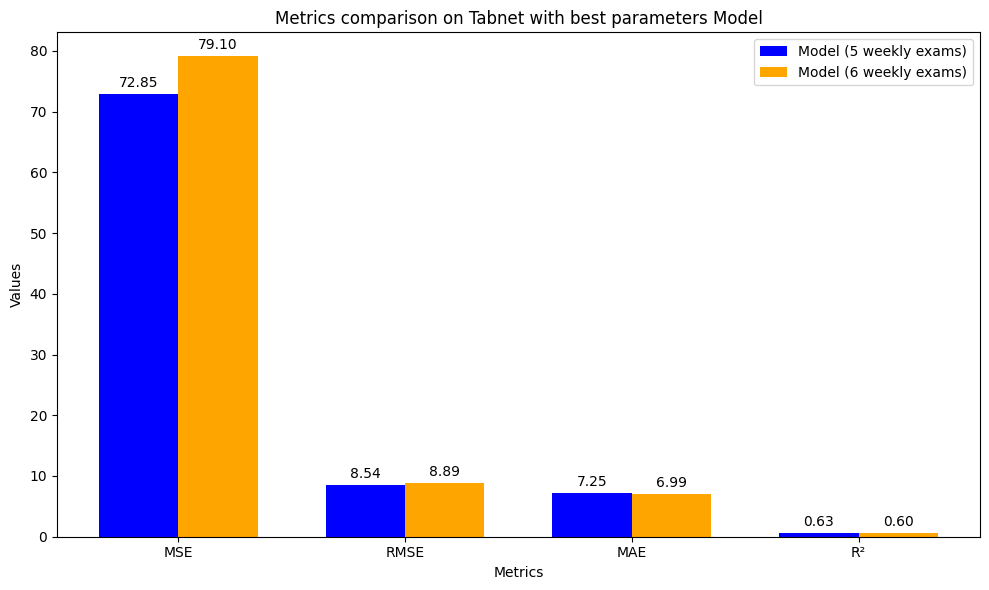

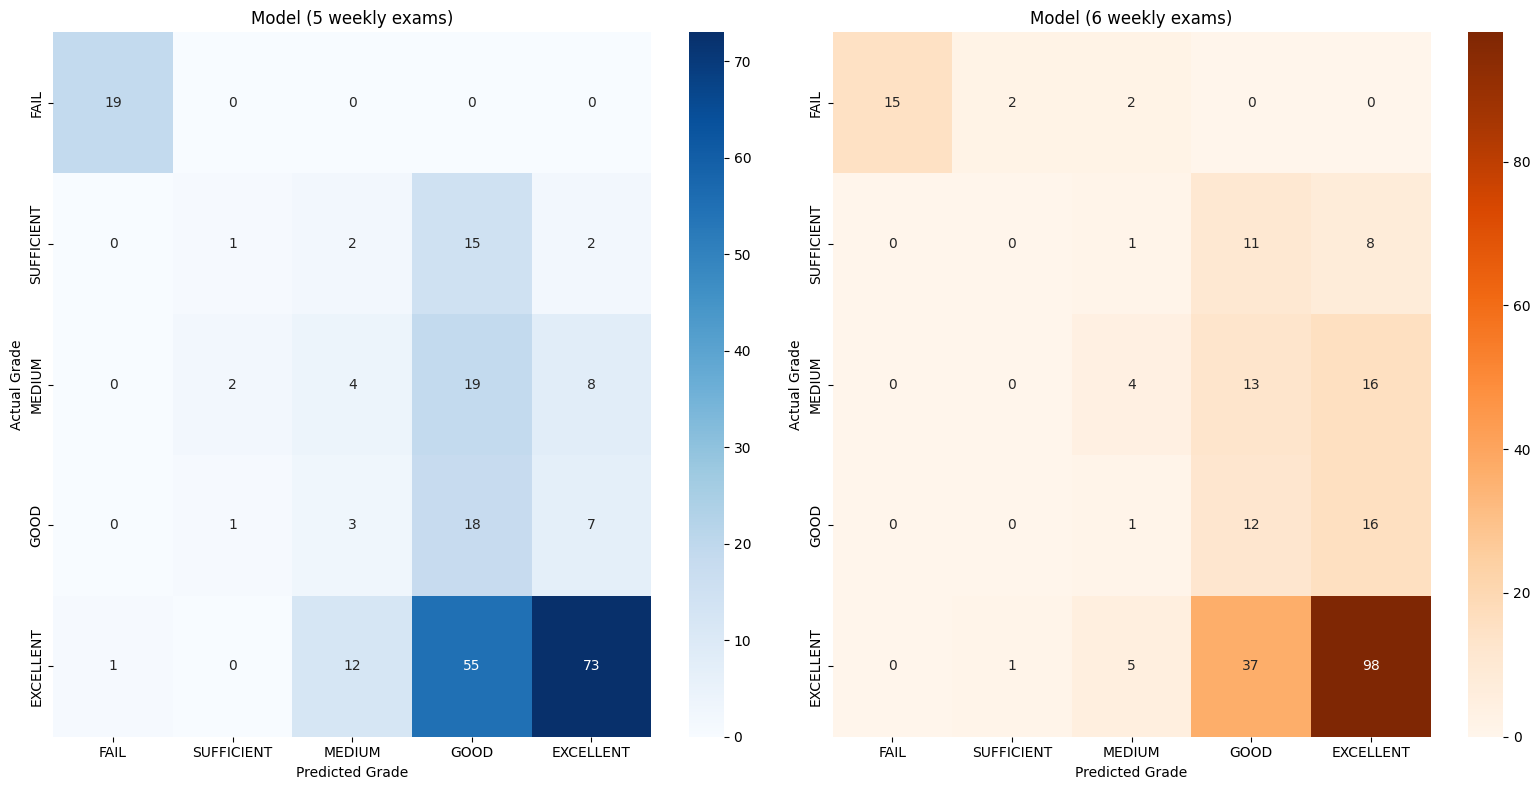

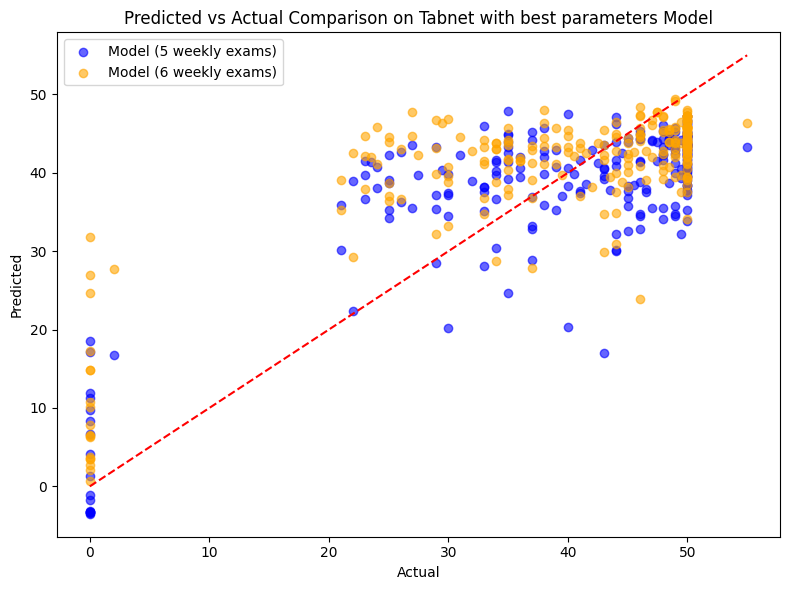

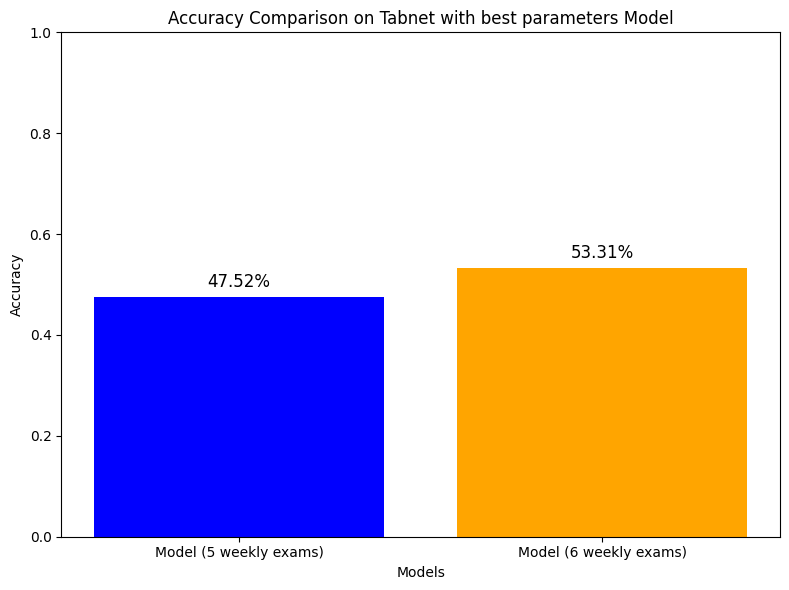

In [110]:
# Metrics calculation
tabnet_metrics_five_best = calculate_metrics(YFive_test, final_predictions_five.ravel())
tabnet_metrics_six_best = calculate_metrics(YSix_test, final_predictions_six.ravel())

metrics = ['MSE', 'RMSE', 'MAE', 'R²']

# Values for each model
tabnet_five_values = [tabnet_metrics_five_best["MSE"], tabnet_metrics_five_best["RMSE"], tabnet_metrics_five_best["MAE"], tabnet_metrics_five_best["R2"]]
tabnet_six_values = [tabnet_metrics_six_best["MSE"], tabnet_metrics_six_best["RMSE"], tabnet_metrics_six_best["MAE"], tabnet_metrics_six_best["R2"]]

# Plots
generate_metrics_comparison(tabnet_five_values, tabnet_six_values,"Metrics comparison on Tabnet with best parameters Model")
generate_confusion_matrices(final_predictions_five.ravel(), final_predictions_six.ravel())
generate_predicted_vs_actual_comparison(YFive_test, final_predictions_five.ravel(), YSix_test, final_predictions_six.ravel(), "Predicted vs Actual Comparison on Tabnet with best parameters Model")
generate_accuracy_comparison(tabnet_metrics_five_best["Accuracy"], tabnet_metrics_six_best["Accuracy"], "Accuracy Comparison on Tabnet with best parameters Model")

**FastAI Model**

In [93]:
data_five = pd.concat([XFive_train, XFive_val])
targets_five = pd.concat([YFive_train, YFive_val])
data_five["target"] = targets_five.values

valid_idx_five = list(range(len(XFive_train), len(data_five)))

data_six = pd.concat([XSix_train, XSix_val])
targets_six = pd.concat([YSix_train, YSix_val])
data_six["target"] = targets_six.values

valid_idx_six = list(range(len(XSix_train), len(data_six)))

dls_five = TabularDataLoaders.from_df(
    df=data_five,
    y_names="target",
    cont_names=list(XFive.columns),
    valid_idx=valid_idx_five,
    procs=[Normalize]
)

dls_six = TabularDataLoaders.from_df(
    df=data_six,
    y_names="target",
    cont_names=list(XSix.columns),
    valid_idx=valid_idx_six,
    procs=[Normalize]
)


learn_five = tabular_learner(dls_five, metrics=[mae, rmse], layers=[200, 100], n_out=1)
learn_five.fit_one_cycle(20, 1e-4)

learn_six = tabular_learner(dls_six, metrics=[mae, rmse], layers=[200, 100], n_out=1)
learn_six.fit_one_cycle(20, 1e-4)

test_preds_five, _ = learn_five.get_preds(dl=dls_five.test_dl(XFive_test))
test_preds_five = test_preds_five.numpy().flatten()
actual_test_five = YFive_test.values

test_preds_six, _ = learn_six.get_preds(dl=dls_six.test_dl(XSix_test))
test_preds_six = test_preds_six.numpy().flatten()
actual_test_six = YSix_test.values

epoch,train_loss,valid_loss,mae,_rmse,time
0,1818.887451,1774.875854,40.690186,42.129276,00:00
1,1794.144409,1775.602051,40.698174,42.137894,00:00
2,1826.954590,1772.633057,40.687618,42.102650,00:00
3,1824.847900,1765.926636,40.659115,42.022930,00:00
4,1815.242065,1760.450806,40.645782,41.957726,00:00
5,1817.816162,1756.831909,40.663254,41.914577,00:00
6,1812.205688,1756.152954,40.706493,41.906479,00:00
7,1816.794800,1745.637451,40.607510,41.780827,00:00
8,1799.516479,1741.321655,40.580509,41.729145,00:00
9,1796.576904,1740.614380,40.605824,41.720673,00:00


epoch,train_loss,valid_loss,mae,_rmse,time
0,1810.847290,1783.945312,40.801891,42.236778,00:00
1,1794.155273,1787.526245,40.852386,42.279148,00:00
2,1800.961914,1782.100708,40.808529,42.214939,00:00
3,1798.548218,1775.713867,40.776443,42.139217,00:00
4,1787.168579,1768.374756,40.733910,42.052048,00:00
5,1790.847534,1765.591431,40.748478,42.018940,00:00
6,1791.371460,1761.769653,40.736320,41.973442,00:00
7,1802.797729,1760.200928,40.753681,41.954746,00:00
8,1806.908325,1754.023682,40.704170,41.881065,00:00
9,1795.428345,1755.294678,40.740158,41.896236,00:00


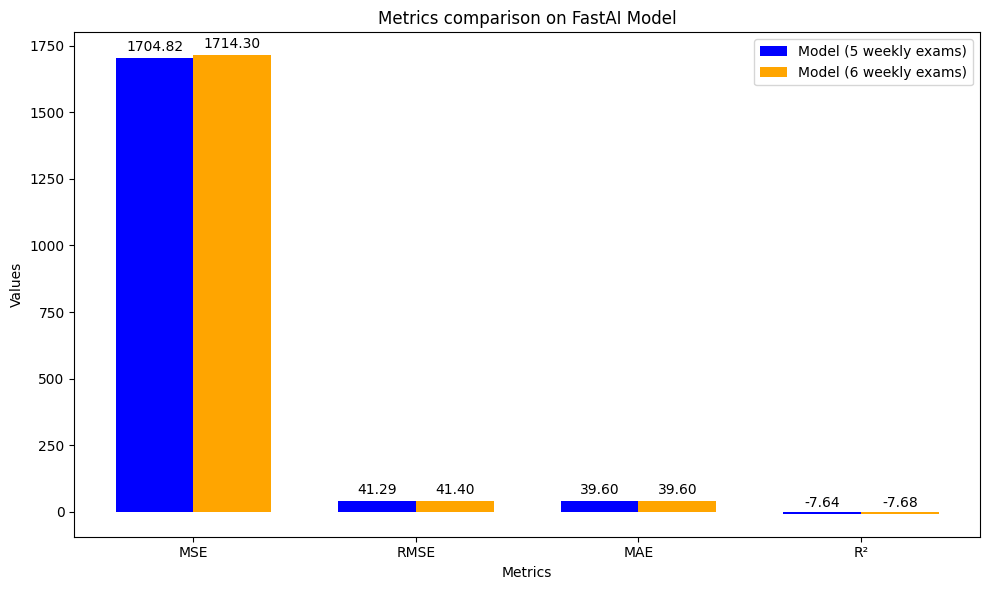

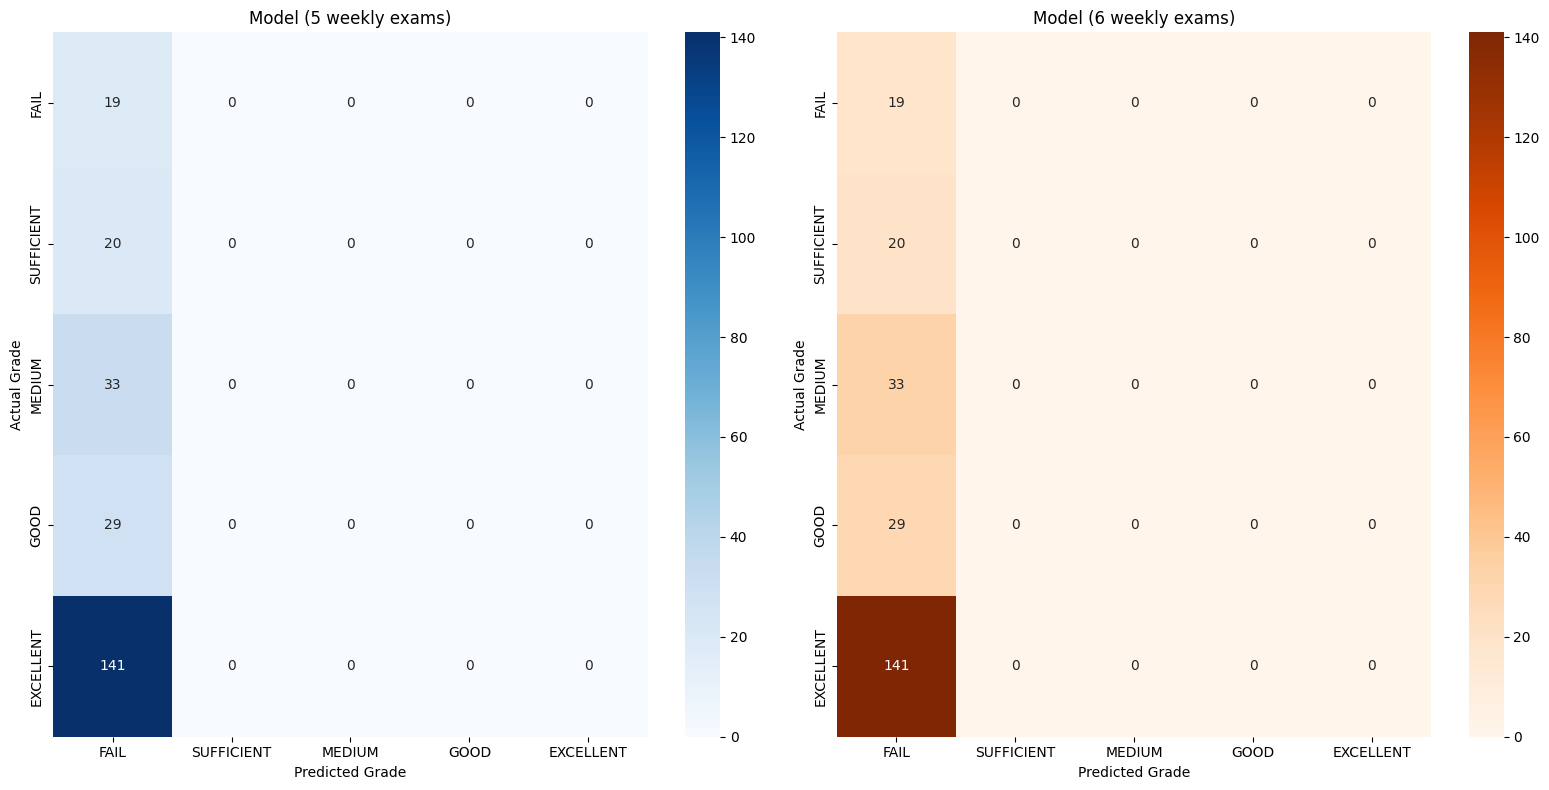

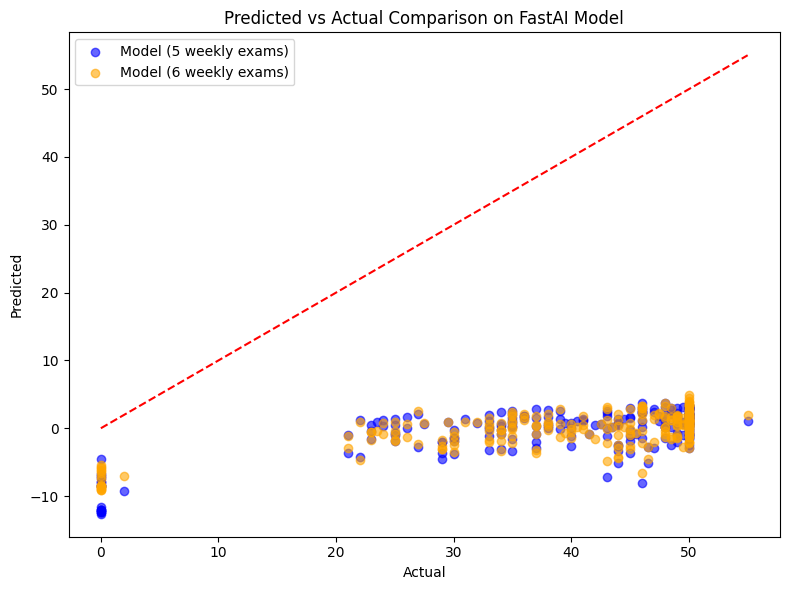

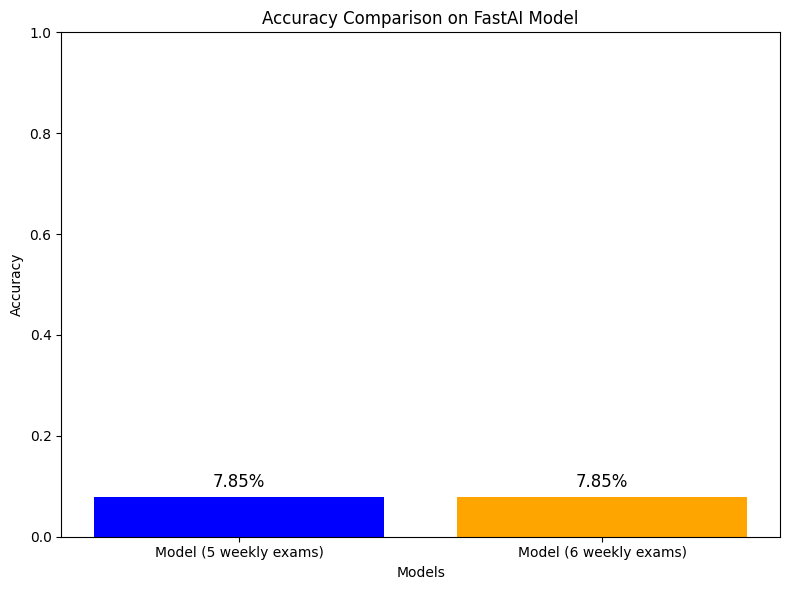

In [111]:
# Metrics calculation
fastai_metrics_five = calculate_metrics(YFive_test, test_preds_five)
fastai_metrics_six = calculate_metrics(YSix_test, test_preds_six)

metrics = ['MSE', 'RMSE', 'MAE', 'R²']

# Values for each model
fastai_five_values = [fastai_metrics_five["MSE"], fastai_metrics_five["RMSE"], fastai_metrics_five["MAE"], fastai_metrics_five["R2"]]
fastai_six_values = [fastai_metrics_six["MSE"], fastai_metrics_six["RMSE"], fastai_metrics_six["MAE"], fastai_metrics_six["R2"]]

# Plots
generate_metrics_comparison(fastai_five_values, fastai_six_values,"Metrics comparison on FastAI Model")
generate_confusion_matrices(test_preds_five, test_preds_six)
generate_predicted_vs_actual_comparison(YFive_test, test_preds_five, YSix_test, test_preds_six, "Predicted vs Actual Comparison on FastAI Model")
generate_accuracy_comparison(fastai_metrics_five["Accuracy"], fastai_metrics_six["Accuracy"], "Accuracy Comparison on FastAI Model")

**FastAI Model with best parameters**

In [95]:
# Merge train + val (for fastai)
data_five = pd.concat([XFive_train, XFive_val])
targets_five = pd.concat([YFive_train, YFive_val])
data_five["target"] = targets_five.values
valid_idx_five = list(range(len(XFive_train), len(data_five)))

data_six = pd.concat([XSix_train, XSix_val])
targets_six = pd.concat([YSix_train, YSix_val])
data_six["target"] = targets_six.values
valid_idx_six = list(range(len(XSix_train), len(data_six)))

dls_five = TabularDataLoaders.from_df(
    data_five,
    y_names="target",
    cont_names=list(XFive.columns),
    valid_idx=valid_idx_five,
    procs=[Normalize]
)

dls_six = TabularDataLoaders.from_df(
    data_six,
    y_names="target",
    cont_names=list(XSix.columns),
    valid_idx=valid_idx_six,
    procs=[Normalize]
)

def objective_five(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
    layer1 = trial.suggest_int('layer1', 100, 250)
    layer2 = trial.suggest_int('layer2', 50, 150)
    wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)

    learn = tabular_learner(
        dls_five,
        metrics=[rmse],
        layers=[layer1, layer2],
        n_out=1,
        wd=wd
    )

    learn.fit_one_cycle(10, learning_rate)
    rmse_value = float(learn.validate()[1])

    return rmse_value

def objective_six(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
    layer1 = trial.suggest_int('layer1', 100, 250)
    layer2 = trial.suggest_int('layer2', 50, 150)
    wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)

    learn = tabular_learner(
        dls_six,
        metrics=[rmse],
        layers=[layer1, layer2],
        n_out=1,
        wd=wd
    )

    learn.fit_one_cycle(10, learning_rate)
    rmse_value = float(learn.validate()[1])

    return rmse_value

study_five = optuna.create_study(direction='minimize')
study_five.optimize(objective_five, n_trials=20)

study_six = optuna.create_study(direction='minimize')
study_six.optimize(objective_six, n_trials=20)

best_params_five = study_five.best_params
best_params_six = study_six.best_params

print("Best Parameters for 5-Exam Model:", best_params_five)
print("Best Parameters for 6-Exam Model:", best_params_six)

learn_five = tabular_learner(
    dls_five,
    metrics=[rmse],
    layers=[best_params_five['layer1'], best_params_five['layer2']],
    n_out=1,
    wd=best_params_five['wd']
)

learn_five.fit_one_cycle(20, best_params_five['learning_rate'])

learn_six = tabular_learner(
    dls_six,
    metrics=[rmse],
    layers=[best_params_six['layer1'], best_params_six['layer2']],
    n_out=1,
    wd=best_params_six['wd']
)

learn_six.fit_one_cycle(20, best_params_six['learning_rate'])

test_preds_five_optimized, _ = learn_five.get_preds(dl=dls_five.test_dl(XFive_test))
test_preds_five_optimized = test_preds_five_optimized.numpy().flatten()
actual_test_five_optimized = YFive_test.values

test_preds_six_optimized, _ = learn_six.get_preds(dl=dls_six.test_dl(XSix_test))
test_preds_six_optimized = test_preds_six_optimized.numpy().flatten()
actual_test_six_optimized = YSix_test.values

[I 2025-04-02 20:10:09,203] A new study created in memory with name: no-name-14b49ca2-5ec9-4813-ada2-12d97501dd4a
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1796.426025,1757.696045,41.924885,00:00
1,1803.021362,1735.770508,41.662579,00:00
2,1787.413208,1694.591064,41.165413,00:00
3,1743.639771,1610.710083,40.133652,00:00
4,1711.099731,1531.885620,39.139309,00:00
5,1686.277466,1523.723633,39.034901,00:00
6,1651.854126,1499.952148,38.729214,00:00
7,1631.986328,1511.780762,38.881626,00:00
8,1599.344116,1491.594604,38.621166,00:00
9,1569.669922,1502.512207,38.762253,00:00


[I 2025-04-02 20:10:10,364] Trial 0 finished with value: 38.76225280761719 and parameters: {'learning_rate': 0.003177976708842141, 'layer1': 208, 'layer2': 60, 'wd': 0.0001}. Best is trial 0 with value: 38.76225280761719.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1757.464966,1765.575195,42.018749,00:00
1,1775.479004,1747.415039,41.802094,00:00
2,1801.818848,1721.669556,41.493008,00:00
3,1791.388794,1705.317383,41.295486,00:00
4,1783.534424,1709.929565,41.351295,00:00
5,1763.924805,1692.453491,41.139442,00:00
6,1745.629272,1681.737671,41.008995,00:00
7,1722.404907,1655.164429,40.683712,00:00
8,1722.200562,1681.411133,41.005016,00:00
9,1703.552734,1668.757446,40.850430,00:00


[I 2025-04-02 20:10:11,528] Trial 1 finished with value: 40.85042953491211 and parameters: {'learning_rate': 0.001177452102636743, 'layer1': 125, 'layer2': 118, 'wd': 0.0001}. Best is trial 0 with value: 38.76225280761719.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1761.284790,1740.537354,41.719749,00:00
1,1732.610107,1553.731934,39.417408,00:00
2,1653.231934,1076.355347,32.807854,00:00
3,1397.685181,555.420105,23.567350,00:00
4,1080.491577,143.877823,11.994909,00:00
5,811.508240,89.038399,9.436016,00:00
6,621.586548,73.290184,8.560968,00:00
7,485.213287,72.390633,8.508269,00:00
8,388.273987,75.210678,8.672409,00:00
9,315.734497,78.299454,8.848699,00:00


[I 2025-04-02 20:10:12,641] Trial 2 finished with value: 8.848698616027832 and parameters: {'learning_rate': 0.013193811544261325, 'layer1': 214, 'layer2': 81, 'wd': 0.0001}. Best is trial 2 with value: 8.848698616027832.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1847.862915,1758.546021,41.935020,00:00
1,1800.022705,1689.184448,41.099689,00:00
2,1725.652832,1311.869873,36.219746,00:00
3,1503.237183,768.861877,27.728357,00:00
4,1215.301025,300.999115,17.349325,00:00
5,933.896484,98.150414,9.907088,00:00
6,714.794556,68.001442,8.246299,00:00
7,556.992493,64.241188,8.015060,00:00
8,440.704498,64.376137,8.023474,00:00
9,353.448883,62.146355,7.883296,00:00


[I 2025-04-02 20:10:13,755] Trial 3 finished with value: 7.883296012878418 and parameters: {'learning_rate': 0.010292410147122186, 'layer1': 192, 'layer2': 107, 'wd': 0.0001}. Best is trial 3 with value: 7.883296012878418.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1789.898560,1707.475586,41.321613,00:00
1,1691.018188,1340.324585,36.610447,00:00
2,1316.951904,473.136627,21.751705,00:00
3,920.024475,164.162140,12.812577,00:00
4,670.967651,69.410027,8.331268,00:00
5,508.684570,81.670891,9.037195,00:00
6,396.821167,74.359955,8.623221,00:00
7,317.375366,66.196869,8.136146,00:00
8,256.976440,64.364655,8.022758,00:00
9,212.547577,65.129852,8.070307,00:00


[I 2025-04-02 20:10:14,865] Trial 4 finished with value: 8.070306777954102 and parameters: {'learning_rate': 0.033225050590064496, 'layer1': 223, 'layer2': 65, 'wd': 0.0001}. Best is trial 3 with value: 7.883296012878418.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1826.007812,1777.171265,42.156509,00:00
1,1829.933472,1753.391724,41.873520,00:00
2,1812.581421,1693.944702,41.157558,00:00
3,1779.497559,1638.529053,40.478748,00:00
4,1758.398193,1614.706055,40.183403,00:00
5,1714.443726,1526.689453,39.072872,00:00
6,1679.449951,1533.510864,39.160069,00:00
7,1635.812378,1486.267212,38.552135,00:00
8,1604.927979,1484.555298,38.529926,00:00
9,1602.155518,1513.077271,38.898293,00:00


[I 2025-04-02 20:10:15,969] Trial 5 finished with value: 38.898292541503906 and parameters: {'learning_rate': 0.003078396098659399, 'layer1': 197, 'layer2': 64, 'wd': 0.0001}. Best is trial 3 with value: 7.883296012878418.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1816.205566,1744.272095,41.764481,00:00
1,1766.979492,1385.865967,37.227222,00:00
2,1430.022339,291.203308,17.064680,00:00
3,991.715515,157.443329,12.547643,00:00
4,722.570007,70.380775,8.389325,00:00
5,546.131042,66.758484,8.170587,00:00
6,423.839386,73.809921,8.591269,00:00
7,337.289978,61.813175,7.862136,00:00
8,274.288269,61.270950,7.827576,00:00
9,226.357269,60.937199,7.806228,00:00


[I 2025-04-02 20:10:17,058] Trial 6 finished with value: 7.806228160858154 and parameters: {'learning_rate': 0.03139192315034878, 'layer1': 190, 'layer2': 59, 'wd': 0.0001}. Best is trial 6 with value: 7.806228160858154.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1762.641968,1755.529663,41.899044,00:00
1,1763.541016,1703.360840,41.271793,00:00
2,1775.082642,1665.064331,40.805202,00:00
3,1737.653809,1581.010010,39.761917,00:00
4,1685.693726,1519.728638,38.983696,00:00
5,1635.418579,1432.323120,37.846043,00:00
6,1576.981079,1352.314697,36.773830,00:00
7,1534.321411,1366.296997,36.963455,00:00
8,1482.945068,1339.050537,36.593037,00:00
9,1437.529053,1297.511963,36.020992,00:00


[I 2025-04-02 20:10:18,151] Trial 7 finished with value: 36.020992279052734 and parameters: {'learning_rate': 0.0033984698178922057, 'layer1': 177, 'layer2': 101, 'wd': 0.0001}. Best is trial 6 with value: 7.806228160858154.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1811.217651,1753.614014,41.876175,00:00
1,1778.772339,1693.279053,41.149471,00:00
2,1734.276001,1436.331177,37.898960,00:00
3,1583.073608,997.998596,31.591116,00:00
4,1374.391968,584.079773,24.167742,00:00
5,1120.153076,335.331604,18.312061,00:00
6,895.455994,190.451279,13.800409,00:00
7,713.151184,137.666992,11.733158,00:00
8,571.800049,108.742744,10.427979,00:00
9,466.229980,105.080589,10.250882,00:00


[I 2025-04-02 20:10:19,265] Trial 8 finished with value: 10.250882148742676 and parameters: {'learning_rate': 0.007977183390470717, 'layer1': 210, 'layer2': 119, 'wd': 0.0001}. Best is trial 6 with value: 7.806228160858154.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1780.206055,1765.208008,42.014378,00:00
1,1751.775757,1657.253906,40.709385,00:00
2,1709.296143,1473.660278,38.388283,00:00
3,1606.069824,1098.179321,33.138790,00:00
4,1435.465820,768.702637,27.725487,00:00
5,1225.502319,466.194946,21.591549,00:00
6,1021.608948,306.228302,17.499380,00:00
7,839.618896,239.118484,15.463456,00:00
8,698.105835,224.533859,14.984454,00:00
9,590.760193,229.172333,15.138438,00:00


[I 2025-04-02 20:10:20,377] Trial 9 finished with value: 15.13843822479248 and parameters: {'learning_rate': 0.006769417558673807, 'layer1': 107, 'layer2': 140, 'wd': 0.0001}. Best is trial 6 with value: 7.806228160858154.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1763.291504,1667.302368,40.832615,00:00
1,1620.152954,660.938293,25.708719,00:00
2,1078.312378,225.314346,15.010475,00:00
3,750.937439,170.121078,13.043048,00:00
4,552.637329,69.136429,8.314832,00:00
5,420.681824,79.875008,8.937283,00:00
6,332.760406,63.556721,7.972247,00:00
7,267.757446,62.407570,7.899847,00:00
8,221.401031,61.198639,7.822956,00:00
9,183.558380,62.039169,7.876494,00:00


[I 2025-04-02 20:10:21,526] Trial 10 finished with value: 7.876494407653809 and parameters: {'learning_rate': 0.04747986549383792, 'layer1': 250, 'layer2': 88, 'wd': 0.0001}. Best is trial 6 with value: 7.806228160858154.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1800.129150,1671.799316,40.887642,00:00
1,1596.848389,648.820251,25.471951,00:00
2,1079.334473,526.035767,22.935471,00:00
3,752.023254,103.449013,10.170988,00:00
4,552.507568,82.633522,9.090298,00:00
5,421.478821,66.718636,8.168148,00:00
6,333.082031,69.598679,8.342583,00:00
7,268.805023,63.316139,7.957144,00:00
8,222.582352,62.784340,7.923657,00:00
9,187.054672,63.114590,7.944469,00:00


[I 2025-04-02 20:10:22,671] Trial 11 finished with value: 7.944469451904297 and parameters: {'learning_rate': 0.047461339574664425, 'layer1': 250, 'layer2': 83, 'wd': 0.0001}. Best is trial 6 with value: 7.806228160858154.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1778.327026,1728.250488,41.572227,00:00
1,1733.595093,1438.192993,37.923515,00:00
2,1484.599854,480.681580,21.924452,00:00
3,1045.123901,154.239212,12.419308,00:00
4,764.023804,97.056702,9.851736,00:00
5,574.884949,67.999863,8.246202,00:00
6,447.070099,60.436981,7.774122,00:00
7,352.485687,60.649124,7.787754,00:00
8,285.980530,60.539639,7.780722,00:00
9,236.147095,60.186153,7.757974,00:00


[I 2025-04-02 20:10:23,794] Trial 12 finished with value: 7.757973670959473 and parameters: {'learning_rate': 0.02329401611057567, 'layer1': 151, 'layer2': 81, 'wd': 0.0001}. Best is trial 12 with value: 7.757973670959473.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1777.195190,1751.448608,41.850311,00:00
1,1741.404907,1546.606934,39.326923,00:00
2,1601.159790,835.808960,28.910360,00:00
3,1246.041138,186.678329,13.663028,00:00
4,902.952820,82.184586,9.065572,00:00
5,683.174500,90.156898,9.495099,00:00
6,528.490601,62.764175,7.922384,00:00
7,415.943481,63.864780,7.991544,00:00
8,333.318054,63.553429,7.972040,00:00
9,271.592590,61.681835,7.853778,00:00


[I 2025-04-02 20:10:24,941] Trial 13 finished with value: 7.85377836227417 and parameters: {'learning_rate': 0.02109851950692669, 'layer1': 148, 'layer2': 55, 'wd': 0.0001}. Best is trial 12 with value: 7.757973670959473.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1808.480591,1728.743530,41.578163,00:00
1,1727.587280,1379.714478,37.144508,00:00
2,1520.201050,658.538879,25.662012,00:00
3,1099.530273,83.570747,9.141704,00:00
4,800.894592,127.994812,11.313478,00:00
5,603.029907,66.493050,8.154326,00:00
6,466.352112,62.336376,7.895339,00:00
7,368.172791,63.674049,7.979602,00:00
8,296.061432,68.318993,8.265531,00:00
9,244.920776,72.034637,8.487323,00:00


[I 2025-04-02 20:10:26,078] Trial 14 finished with value: 8.487322807312012 and parameters: {'learning_rate': 0.022057900991791488, 'layer1': 156, 'layer2': 71, 'wd': 0.0001}. Best is trial 12 with value: 7.757973670959473.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1804.985352,1753.078003,41.869774,00:00
1,1799.451416,1541.134277,39.257282,00:00
2,1646.276733,900.460693,30.007677,00:00
3,1320.951050,261.436554,16.169001,00:00
4,977.026306,85.613823,9.252774,00:00
5,731.507568,97.077492,9.852791,00:00
6,565.003052,73.675056,8.583417,00:00
7,442.850952,67.407127,8.210184,00:00
8,352.906799,68.531586,8.278380,00:00
9,286.855286,65.567978,8.097406,00:00


[I 2025-04-02 20:10:27,196] Trial 15 finished with value: 8.097406387329102 and parameters: {'learning_rate': 0.019278251895816983, 'layer1': 153, 'layer2': 50, 'wd': 0.0001}. Best is trial 12 with value: 7.757973670959473.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1766.322998,1705.674316,41.299809,00:00
1,1677.142334,1111.663086,33.341614,00:00
2,1316.648560,136.278641,11.673844,00:00
3,914.283691,106.309937,10.310671,00:00
4,661.027771,81.815582,9.045196,00:00
5,503.099823,68.754242,8.291818,00:00
6,392.027679,67.377647,8.208389,00:00
7,313.617249,65.532066,8.095188,00:00
8,256.213074,64.256653,8.016025,00:00
9,211.645996,64.012131,8.000758,00:00


[I 2025-04-02 20:10:28,389] Trial 16 finished with value: 8.000758171081543 and parameters: {'learning_rate': 0.031085515039416665, 'layer1': 171, 'layer2': 74, 'wd': 0.0001}. Best is trial 12 with value: 7.757973670959473.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1805.903198,1757.043945,41.917107,00:00
1,1772.847290,1668.740845,40.850224,00:00
2,1622.855713,1032.147095,32.127048,00:00
3,1314.142090,288.686798,16.990788,00:00
4,965.711731,97.057289,9.851767,00:00
5,722.338562,77.488846,8.802774,00:00
6,556.152893,68.940857,8.303063,00:00
7,436.543457,64.801353,8.049929,00:00
8,350.435181,63.675102,7.979668,00:00
9,284.790771,63.111595,7.944281,00:00


[I 2025-04-02 20:10:29,527] Trial 17 finished with value: 7.944280624389648 and parameters: {'learning_rate': 0.01472064725429243, 'layer1': 132, 'layer2': 94, 'wd': 0.0001}. Best is trial 12 with value: 7.757973670959473.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1747.266235,1768.836060,42.057533,00:00
1,1752.846313,1716.964111,41.436264,00:00
2,1701.485718,1503.416260,38.773911,00:00
3,1615.634888,1179.244873,34.340130,00:00
4,1467.072388,879.560730,29.657391,00:00
5,1276.706299,576.397095,24.008272,00:00
6,1075.532837,416.948090,20.419306,00:00
7,905.308960,342.781372,18.514357,00:00
8,771.583130,329.510437,18.152422,00:00
9,670.136658,333.752594,18.268896,00:00


[I 2025-04-02 20:10:30,701] Trial 18 finished with value: 18.268896102905273 and parameters: {'learning_rate': 0.006035982937303883, 'layer1': 181, 'layer2': 150, 'wd': 0.0001}. Best is trial 12 with value: 7.757973670959473.
<ipython-input-95-818bf132da22>:29: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:32: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1746.988525,1717.989380,41.448635,00:00
1,1681.932373,1396.943848,37.375713,00:00
2,1389.923828,281.689240,16.783600,00:00
3,965.244873,228.562622,15.118288,00:00
4,706.770264,67.627129,8.223572,00:00
5,534.253540,74.783600,8.647752,00:00
6,417.673096,64.260201,8.016246,00:00
7,331.972870,61.867161,7.865568,00:00
8,270.236511,61.029999,7.812170,00:00
9,223.142410,61.128757,7.818489,00:00


[I 2025-04-02 20:10:31,913] Trial 19 finished with value: 7.818488597869873 and parameters: {'learning_rate': 0.02781087858991331, 'layer1': 164, 'layer2': 72, 'wd': 0.0001}. Best is trial 12 with value: 7.757973670959473.
[I 2025-04-02 20:10:31,914] A new study created in memory with name: no-name-5bcdc8b9-6727-4f76-92cc-d991e17f0735
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1859.276245,1781.855591,42.212032,00:00
1,1828.808594,1748.767334,41.818264,00:00
2,1850.064209,1750.222534,41.835663,00:00
3,1808.747681,1669.494263,40.859447,00:00
4,1778.958374,1649.758789,40.617222,00:00
5,1744.866455,1616.961914,40.211468,00:00
6,1723.984131,1633.812012,40.420441,00:00
7,1702.523926,1605.250610,40.065578,00:00
8,1689.678711,1605.107056,40.063789,00:00
9,1674.725952,1605.243286,40.065487,00:00


[I 2025-04-02 20:10:33,233] Trial 0 finished with value: 40.065486907958984 and parameters: {'learning_rate': 0.0018593364366259208, 'layer1': 214, 'layer2': 92, 'wd': 0.0001}. Best is trial 0 with value: 40.065486907958984.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1811.266357,1756.871460,41.915051,00:00
1,1757.790771,1638.376221,40.476860,00:00
2,1664.645996,1035.889648,32.185238,00:00
3,1363.936035,334.263916,18.282887,00:00
4,1007.687195,109.044708,10.442447,00:00
5,752.554321,75.139671,8.668314,00:00
6,578.401306,75.063164,8.663900,00:00
7,454.837341,63.053005,7.940592,00:00
8,363.303314,62.938580,7.933384,00:00
9,295.468567,63.721149,7.982553,00:00


[I 2025-04-02 20:10:34,484] Trial 1 finished with value: 7.982553005218506 and parameters: {'learning_rate': 0.012967096229380512, 'layer1': 110, 'layer2': 116, 'wd': 0.0001}. Best is trial 1 with value: 7.982553005218506.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1803.166870,1748.278687,41.812424,00:00
1,1760.802490,1466.120972,38.289959,00:00
2,1475.153198,474.206207,21.776276,00:00
3,1032.238159,155.014801,12.450495,00:00
4,751.956299,70.305931,8.384862,00:00
5,567.299316,68.338814,8.266729,00:00
6,438.441223,63.031796,7.939257,00:00
7,347.393280,66.717209,8.168060,00:00
8,280.397766,64.863678,8.053800,00:00
9,229.616806,64.765472,8.047700,00:00


[I 2025-04-02 20:10:35,628] Trial 2 finished with value: 8.047699928283691 and parameters: {'learning_rate': 0.021006843268504095, 'layer1': 196, 'layer2': 115, 'wd': 0.0001}. Best is trial 1 with value: 7.982553005218506.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1752.510010,1750.386108,41.837616,00:00
1,1739.991577,1618.612305,40.231979,00:00
2,1644.028076,1088.896362,32.998428,00:00
3,1390.530640,527.125854,22.959221,00:00
4,1062.680176,127.827583,11.306087,00:00
5,794.587036,71.856812,8.476839,00:00
6,608.215881,79.050568,8.891038,00:00
7,474.930908,71.742874,8.470117,00:00
8,378.028259,66.484413,8.153797,00:00
9,304.674652,65.443268,8.089702,00:00


[I 2025-04-02 20:10:36,769] Trial 3 finished with value: 8.089701652526855 and parameters: {'learning_rate': 0.010849829977645109, 'layer1': 146, 'layer2': 134, 'wd': 0.0001}. Best is trial 1 with value: 7.982553005218506.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1825.770752,1771.842285,42.093258,00:00
1,1800.171753,1737.732544,41.686119,00:00
2,1776.821533,1693.220337,41.148758,00:00
3,1750.899048,1658.801880,40.728390,00:00
4,1735.967041,1618.866455,40.235142,00:00
5,1700.555176,1564.388428,39.552349,00:00
6,1680.774902,1546.579834,39.326580,00:00
7,1654.701538,1531.799805,39.138214,00:00
8,1634.900635,1528.937866,39.101635,00:00
9,1612.639038,1538.527466,39.224068,00:00


[I 2025-04-02 20:10:37,889] Trial 4 finished with value: 39.22406768798828 and parameters: {'learning_rate': 0.002827632041983211, 'layer1': 234, 'layer2': 54, 'wd': 0.0001}. Best is trial 1 with value: 7.982553005218506.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1844.828491,1763.699219,41.996418,00:00
1,1810.150146,1705.564331,41.298477,00:00
2,1769.558960,1637.576294,40.466976,00:00
3,1726.855713,1527.126587,39.078468,00:00
4,1659.786377,1395.960449,37.362553,00:00
5,1582.092285,1288.401245,35.894310,00:00
6,1499.840820,1191.185547,34.513554,00:00
7,1423.046143,1146.839600,33.865021,00:00
8,1348.053955,1104.635254,33.236053,00:00
9,1285.841064,1098.357178,33.141472,00:00


[I 2025-04-02 20:10:39,026] Trial 5 finished with value: 33.14147186279297 and parameters: {'learning_rate': 0.003726360042779042, 'layer1': 102, 'layer2': 130, 'wd': 0.0001}. Best is trial 1 with value: 7.982553005218506.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1833.121948,1713.314819,41.392204,00:00
1,1645.763550,903.713196,30.061825,00:00
2,1114.712769,204.487198,14.299903,00:00
3,773.371216,143.955734,11.998156,00:00
4,564.924377,76.166977,8.727369,00:00
5,430.139648,68.278725,8.263094,00:00
6,337.662689,67.588181,8.221204,00:00
7,271.163483,68.182137,8.257247,00:00
8,221.967331,65.339760,8.083301,00:00
9,186.411636,64.107010,8.006686,00:00


[I 2025-04-02 20:10:40,193] Trial 6 finished with value: 8.006686210632324 and parameters: {'learning_rate': 0.03964482588932717, 'layer1': 111, 'layer2': 111, 'wd': 0.0001}. Best is trial 1 with value: 7.982553005218506.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1790.398071,1750.922607,41.844025,00:00
1,1813.922363,1716.425659,41.429768,00:00
2,1782.135986,1655.108398,40.683025,00:00
3,1731.901978,1521.335815,39.004307,00:00
4,1683.398071,1462.611206,38.244099,00:00
5,1612.736450,1356.577026,36.831738,00:00
6,1554.788696,1305.467896,36.131260,00:00
7,1496.712402,1267.890015,35.607441,00:00
8,1442.536743,1253.653564,35.406971,00:00
9,1391.892334,1215.253906,34.860489,00:00


[I 2025-04-02 20:10:41,320] Trial 7 finished with value: 34.86048889160156 and parameters: {'learning_rate': 0.00407840273046112, 'layer1': 223, 'layer2': 72, 'wd': 0.0001}. Best is trial 1 with value: 7.982553005218506.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1836.056885,1773.139648,42.108665,00:00
1,1791.478149,1746.671631,41.793201,00:00
2,1787.543335,1718.539551,41.455273,00:00
3,1772.300903,1680.924561,40.999081,00:00
4,1753.151367,1670.107056,40.866943,00:00
5,1746.936279,1679.799805,40.985363,00:00
6,1733.444580,1663.169067,40.781971,00:00
7,1705.336304,1646.551392,40.577721,00:00
8,1690.426147,1630.715454,40.382122,00:00
9,1675.047241,1599.055908,39.988197,00:00


[I 2025-04-02 20:10:42,449] Trial 8 finished with value: 39.988197326660156 and parameters: {'learning_rate': 0.0016474753346283875, 'layer1': 160, 'layer2': 136, 'wd': 0.0001}. Best is trial 1 with value: 7.982553005218506.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1764.593018,1763.446289,41.993408,00:00
1,1779.002075,1730.645874,41.601032,00:00
2,1773.417603,1707.080078,41.316830,00:00
3,1763.269287,1695.189941,41.172688,00:00
4,1746.672852,1654.314697,40.673267,00:00
5,1718.295410,1625.961548,40.323212,00:00
6,1688.519043,1584.636719,39.807495,00:00
7,1670.990845,1614.597290,40.182053,00:00
8,1659.183228,1582.140991,39.776134,00:00
9,1643.962646,1589.863647,39.873093,00:00


[I 2025-04-02 20:10:43,581] Trial 9 finished with value: 39.87309265136719 and parameters: {'learning_rate': 0.001671941654246021, 'layer1': 122, 'layer2': 148, 'wd': 0.0001}. Best is trial 1 with value: 7.982553005218506.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1811.323486,1744.331177,41.765190,00:00
1,1772.887085,1632.305786,40.401806,00:00
2,1723.008301,1379.531372,37.142040,00:00
3,1543.372437,871.584351,29.522608,00:00
4,1270.784424,413.647247,20.338318,00:00
5,1009.083252,167.379074,12.937507,00:00
6,783.233398,114.082550,10.680944,00:00
7,610.052429,69.019066,8.307772,00:00
8,481.731903,63.804676,7.987783,00:00
9,386.490479,64.517563,8.032283,00:00


[I 2025-04-02 20:10:44,737] Trial 10 finished with value: 8.032282829284668 and parameters: {'learning_rate': 0.010195089066833063, 'layer1': 178, 'layer2': 92, 'wd': 0.0001}. Best is trial 1 with value: 7.982553005218506.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1744.067993,1691.615356,41.129253,00:00
1,1597.644653,492.494690,22.192223,00:00
2,1047.244141,288.839417,16.995275,00:00
3,722.990662,95.935806,9.794683,00:00
4,529.359009,66.903473,8.179454,00:00
5,404.450653,66.367699,8.146638,00:00
6,318.283936,67.683441,8.226995,00:00
7,255.595596,61.816280,7.862333,00:00
8,209.490845,61.720192,7.856220,00:00
9,175.432571,62.339706,7.895550,00:00


[I 2025-04-02 20:10:45,913] Trial 11 finished with value: 7.895549774169922 and parameters: {'learning_rate': 0.048388099329975925, 'layer1': 127, 'layer2': 110, 'wd': 0.0001}. Best is trial 11 with value: 7.895549774169922.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1758.108643,1692.128052,41.135490,00:00
1,1580.459717,540.557129,23.249884,00:00
2,1038.181030,181.008820,13.453951,00:00
3,719.490845,136.013718,11.662491,00:00
4,528.592285,63.329689,7.957995,00:00
5,403.791077,90.182167,9.496428,00:00
6,320.273071,56.382679,7.508840,00:00
7,258.560394,61.520554,7.843504,00:00
8,213.201492,55.670334,7.461256,00:00
9,178.432266,55.516342,7.450929,00:00


[I 2025-04-02 20:10:47,083] Trial 12 finished with value: 7.450929164886475 and parameters: {'learning_rate': 0.04761361565986954, 'layer1': 136, 'layer2': 109, 'wd': 0.0001}. Best is trial 12 with value: 7.450929164886475.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1806.402222,1692.232056,41.136745,00:00
1,1644.715942,835.227051,28.900297,00:00
2,1112.176514,313.695557,17.711452,00:00
3,770.252380,84.966370,9.217721,00:00
4,564.491089,89.354088,9.452730,00:00
5,432.556732,63.684998,7.980288,00:00
6,338.657715,60.945496,7.806760,00:00
7,271.066132,62.862743,7.928603,00:00
8,220.592194,63.005882,7.937624,00:00
9,182.606369,62.909840,7.931572,00:00


[I 2025-04-02 20:10:48,227] Trial 13 finished with value: 7.931572437286377 and parameters: {'learning_rate': 0.03929528278706228, 'layer1': 139, 'layer2': 102, 'wd': 0.0001}. Best is trial 12 with value: 7.450929164886475.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1777.350098,1728.608398,41.576534,00:00
1,1710.290894,1427.046143,37.776264,00:00
2,1477.548706,564.661438,23.762606,00:00
3,1051.113281,122.210342,11.054878,00:00
4,768.571167,115.049057,10.726092,00:00
5,579.295715,70.825157,8.415768,00:00
6,449.659882,69.099968,8.312639,00:00
7,356.061829,66.765915,8.171041,00:00
8,287.656799,65.425827,8.088624,00:00
9,234.925613,65.467766,8.091215,00:00


[I 2025-04-02 20:10:49,363] Trial 14 finished with value: 8.091215133666992 and parameters: {'learning_rate': 0.021719081543904683, 'layer1': 136, 'layer2': 83, 'wd': 0.0001}. Best is trial 12 with value: 7.450929164886475.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1774.311523,1712.352173,41.380577,00:00
1,1593.388672,713.305786,26.707787,00:00
2,1055.477661,236.448257,15.376874,00:00
3,736.553955,84.906219,9.214458,00:00
4,539.868103,81.538689,9.029878,00:00
5,410.210144,68.879456,8.299364,00:00
6,322.148987,73.875076,8.595062,00:00
7,260.311890,66.291382,8.141952,00:00
8,212.929443,69.800751,8.354685,00:00
9,178.499985,64.875290,8.054520,00:00


[I 2025-04-02 20:10:50,507] Trial 15 finished with value: 8.054519653320312 and parameters: {'learning_rate': 0.04387293378780551, 'layer1': 166, 'layer2': 122, 'wd': 0.0001}. Best is trial 12 with value: 7.450929164886475.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1860.990723,1730.579956,41.600239,00:00
1,1780.359741,1401.921143,37.442238,00:00
2,1460.506348,158.874252,12.604533,00:00
3,1012.774658,341.158386,18.470474,00:00
4,738.115173,72.977142,8.542666,00:00
5,556.300171,65.403290,8.087230,00:00
6,430.923218,72.453285,8.511950,00:00
7,343.458435,64.208672,8.013031,00:00
8,275.627686,64.791710,8.049330,00:00
9,225.164658,64.855377,8.053284,00:00


[I 2025-04-02 20:10:51,657] Trial 16 finished with value: 8.05328369140625 and parameters: {'learning_rate': 0.02396525355567616, 'layer1': 127, 'layer2': 99, 'wd': 0.0001}. Best is trial 12 with value: 7.450929164886475.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1802.809937,1759.565430,41.947174,00:00
1,1811.318359,1720.565552,41.479698,00:00
2,1794.237061,1633.109497,40.411751,00:00
3,1703.397949,1392.310913,37.313683,00:00
4,1585.393921,1152.989990,33.955704,00:00
5,1451.874268,967.667847,31.107359,00:00
6,1315.431396,809.164001,28.445808,00:00
7,1181.843140,699.114441,26.440773,00:00
8,1066.557007,671.700317,25.917183,00:00
9,981.213013,676.085815,26.001650,00:00


[I 2025-04-02 20:10:52,782] Trial 17 finished with value: 26.001649856567383 and parameters: {'learning_rate': 0.0065863117528536285, 'layer1': 152, 'layer2': 74, 'wd': 0.0001}. Best is trial 12 with value: 7.450929164886475.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1774.128662,1710.574463,41.359093,00:00
1,1692.527954,1278.463745,35.755611,00:00
2,1241.179321,97.918633,9.895384,00:00
3,861.383667,84.484779,9.191560,00:00
4,625.546692,78.815933,8.877833,00:00
5,474.357056,73.125092,8.551321,00:00
6,370.867279,64.367966,8.022965,00:00
7,295.836945,62.250015,7.889867,00:00
8,242.485352,63.837894,7.989862,00:00
9,199.994736,61.929935,7.869557,00:00


[I 2025-04-02 20:10:53,932] Trial 18 finished with value: 7.8695573806762695 and parameters: {'learning_rate': 0.03070198771933936, 'layer1': 180, 'layer2': 104, 'wd': 0.0001}. Best is trial 12 with value: 7.450929164886475.
<ipython-input-95-818bf132da22>:48: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-95-818bf132da22>:51: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1779.932495,1722.576294,41.503933,00:00
1,1713.720825,1358.487305,36.857662,00:00
2,1476.666138,450.420135,21.223104,00:00
3,1050.655762,93.711212,9.680455,00:00
4,766.032410,124.648758,11.164620,00:00
5,575.840820,75.360382,8.681036,00:00
6,446.432648,69.882111,8.359552,00:00
7,353.085144,61.459064,7.839583,00:00
8,284.639709,61.048958,7.813383,00:00
9,236.268585,61.270912,7.827574,00:00


[I 2025-04-02 20:10:55,060] Trial 19 finished with value: 7.827573776245117 and parameters: {'learning_rate': 0.025677210526522252, 'layer1': 190, 'layer2': 60, 'wd': 0.0001}. Best is trial 12 with value: 7.450929164886475.


Best Parameters for 5-Exam Model: {'learning_rate': 0.02329401611057567, 'layer1': 151, 'layer2': 81, 'wd': 0.0001}
Best Parameters for 6-Exam Model: {'learning_rate': 0.04761361565986954, 'layer1': 136, 'layer2': 109, 'wd': 0.0001}


epoch,train_loss,valid_loss,_rmse,time
0,1812.896973,1758.677124,41.936584,00:00
1,1775.780884,1623.103760,40.287762,00:00
2,1723.541016,1307.753052,36.162868,00:00
3,1522.787964,499.887787,22.358170,00:00
4,1138.656616,157.001419,12.530020,00:00
5,857.422729,76.662125,8.755691,00:00
6,660.608887,67.541008,8.218333,00:00
7,518.185730,64.134613,8.008409,00:00
8,413.504639,68.852577,8.297746,00:00
9,335.673401,74.919899,8.655628,00:00


epoch,train_loss,valid_loss,_rmse,time
0,1774.182861,1733.488892,41.635189,00:00
1,1712.639038,1523.435547,39.031212,00:00
2,1537.685913,422.269775,20.549204,00:00
3,1096.695923,352.479797,18.774445,00:00
4,805.704224,142.185913,11.924173,00:00
5,606.379761,80.863251,8.992399,00:00
6,469.652252,78.121536,8.838638,00:00
7,370.565277,71.218811,8.439124,00:00
8,301.406891,78.355705,8.851876,00:00
9,246.397079,63.339458,7.958609,00:00


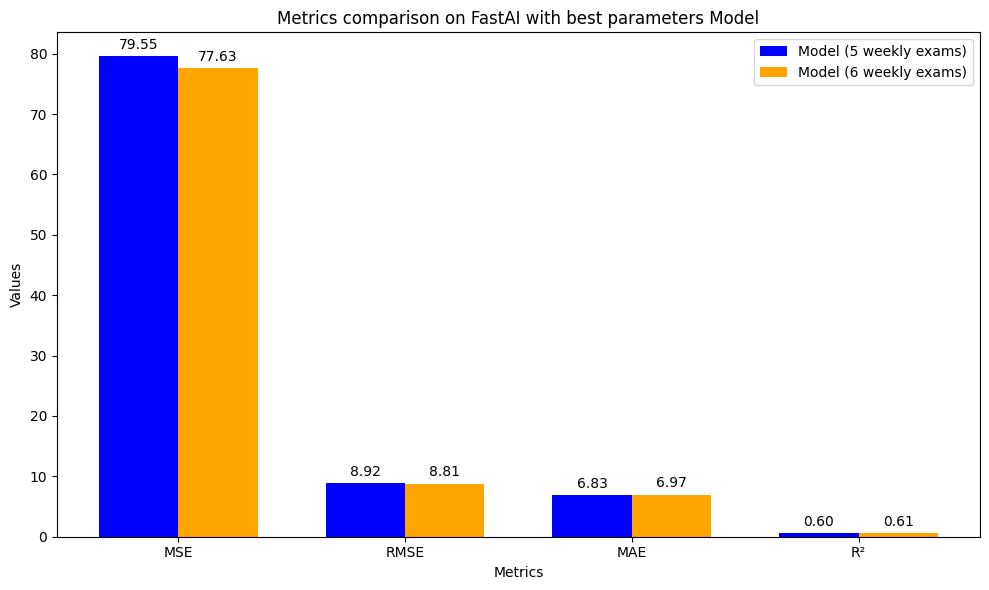

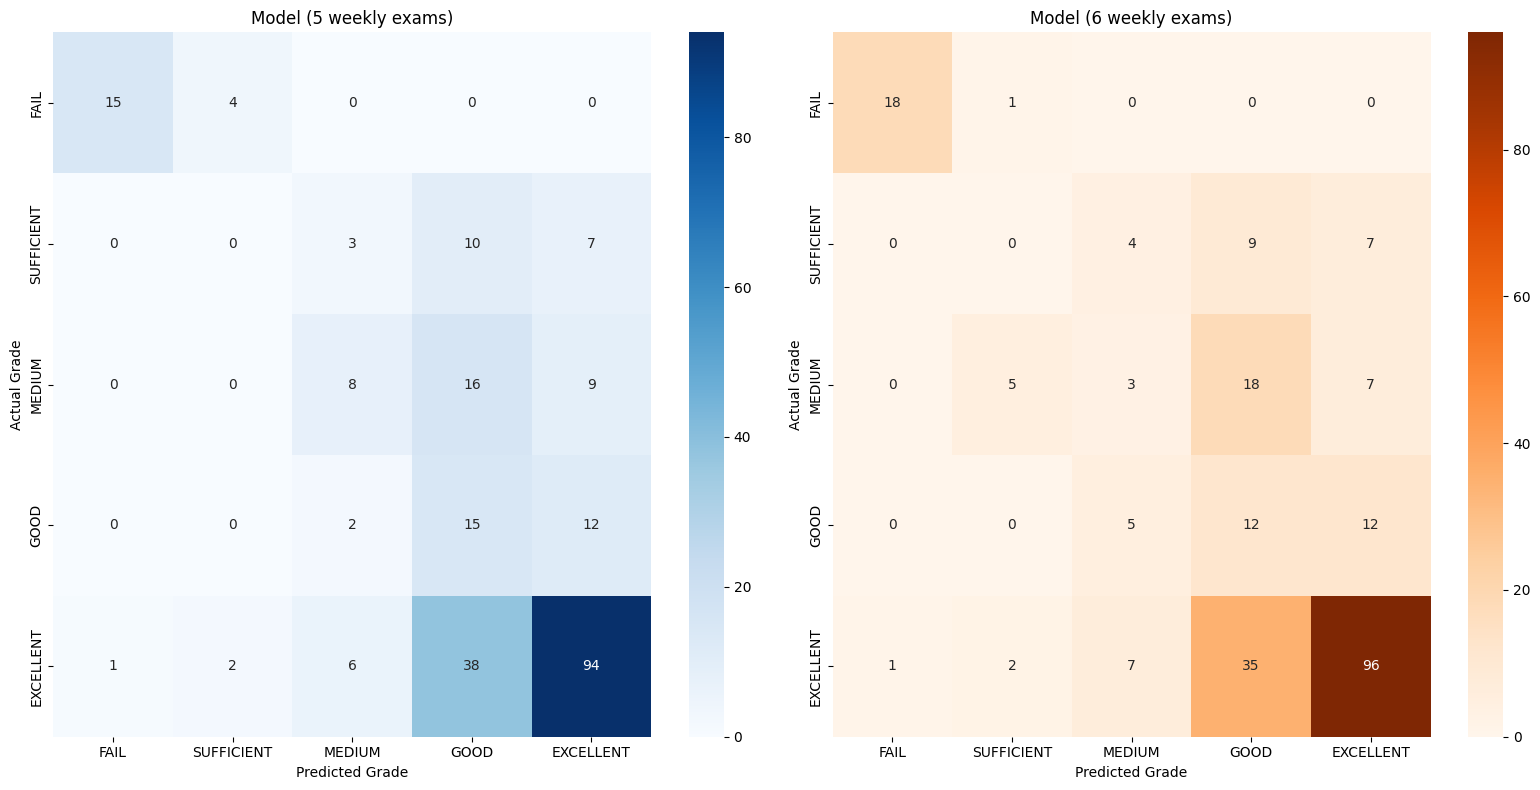

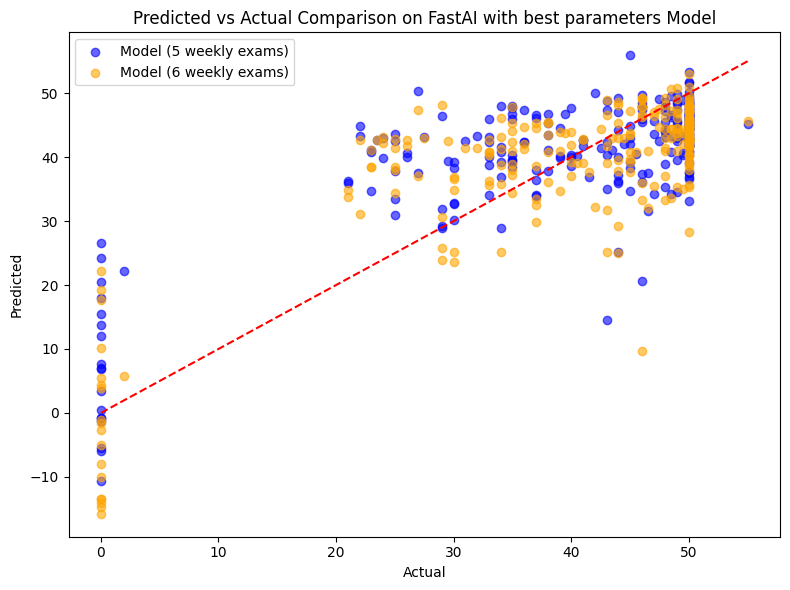

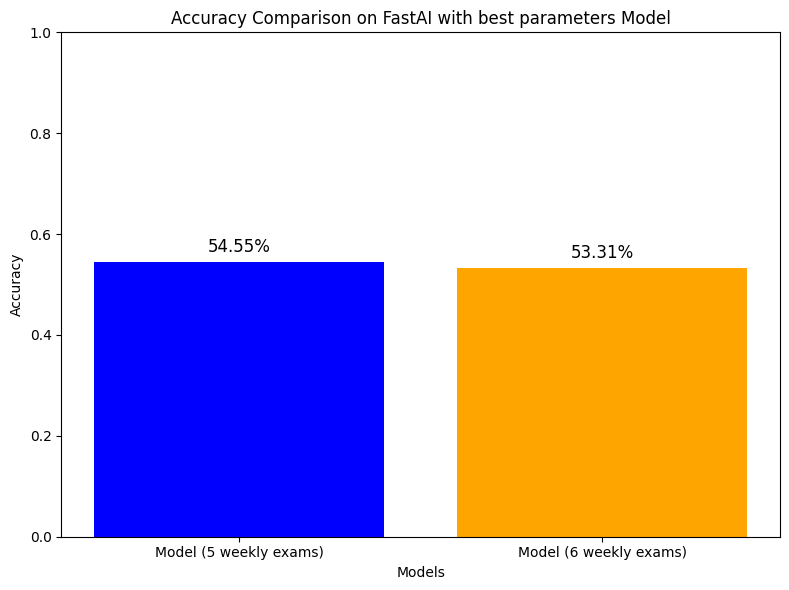

In [112]:
# Metrics calculation
fastai_metrics_five_best = calculate_metrics(YFive_test, test_preds_five_optimized)
fastai_metrics_six_best = calculate_metrics(YSix_test, test_preds_six_optimized)

metrics = ['MSE', 'RMSE', 'MAE', 'R²']

# Values for each model
fastai_best_five_values = [fastai_metrics_five_best["MSE"], fastai_metrics_five_best["RMSE"], fastai_metrics_five_best["MAE"], fastai_metrics_five_best["R2"]]
fastai_best_six_values = [fastai_metrics_six_best["MSE"], fastai_metrics_six_best["RMSE"], fastai_metrics_six_best["MAE"], fastai_metrics_six_best["R2"]]

# Plots
generate_metrics_comparison(fastai_best_five_values, fastai_best_six_values,"Metrics comparison on FastAI with best parameters Model")
generate_confusion_matrices(test_preds_five_optimized, test_preds_six_optimized)
generate_predicted_vs_actual_comparison(YFive_test, test_preds_five_optimized, YSix_test, test_preds_six_optimized, "Predicted vs Actual Comparison on FastAI with best parameters Model")
generate_accuracy_comparison(fastai_metrics_five_best["Accuracy"], fastai_metrics_six_best["Accuracy"], "Accuracy Comparison on FastAI with best parameters Model")

**Comparison**

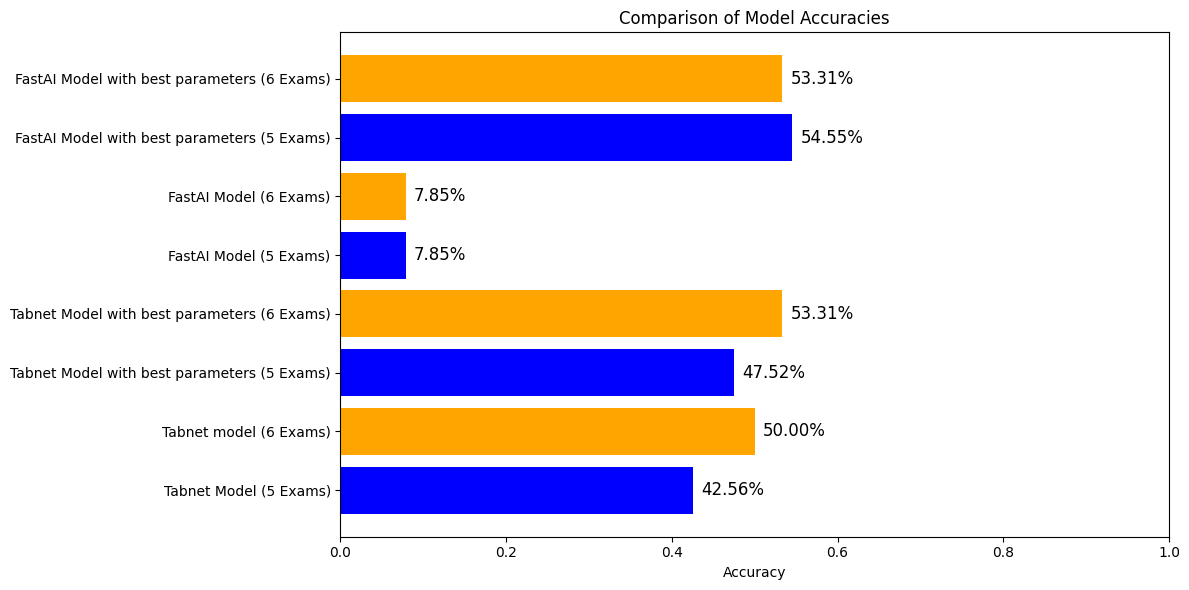

In [113]:
models = [
    "Tabnet Model (5 Exams)", "Tabnet model (6 Exams)",
    "Tabnet Model with best parameters (5 Exams)", "Tabnet Model with best parameters (6 Exams)",
    "FastAI Model (5 Exams)", "FastAI Model (6 Exams)",
    "FastAI Model with best parameters (5 Exams)", "FastAI Model with best parameters (6 Exams)",
]

accuracies = [
    tabnet_metrics_five["Accuracy"], tabnet_metrics_six["Accuracy"],
    tabnet_metrics_five_best["Accuracy"], tabnet_metrics_six_best["Accuracy"],
    fastai_metrics_five["Accuracy"], fastai_metrics_six["Accuracy"],
    fastai_metrics_five_best["Accuracy"], fastai_metrics_six_best["Accuracy"]
]

# Plot comparison of all SVM-based model accuracies
plt.figure(figsize=(12, 6))
plt.barh(models, accuracies, color=['blue', 'orange', 'blue', 'orange', 'blue', 'orange', 'blue', 'orange', 'blue', 'orange'])
plt.xlabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1

# Annotate each bar with accuracy values
for i, acc in enumerate(accuracies):
    plt.text(acc + 0.01, i, f"{acc:.2%}", ha='left', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()